<a href="https://colab.research.google.com/github/sokrypton/GREMLIN_LH/blob/main/GREMLIN_LH_outline_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GREMLIN_LH

In [1]:
# ------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42):
# <haobowang@fas.harvard.edu>,<so@g.harvard.edu> and wrote this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer/an apple cider in return.
# --Sergey Ovchinnikov and Haobo Wang
# ------------------------------------------------------------

#log


*   Add AdK protein instead of GA/GB
*   List item



## Load some libraries

In [2]:
import numpy as np
import matplotlib.pylab as plt
import string
import os
import pandas as pd
import pickle
import scipy.stats
import jax
import jax.numpy as jnp
from jax import tree_util
import optax
from google.colab import files # download files

## Utils

In [3]:
def parse_fasta(filename, a3m=False):
  '''function to parse fasta file'''

  if a3m:
    # for a3m files the lowercase letters are removed
    # as these do not align to the query sequence
    rm_lc = str.maketrans(dict.fromkeys(string.ascii_lowercase))

  header, sequence = [],[]
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if len(line)>0:
      if line[0] == ">":
        header.append(line[1:])
        sequence.append([])
      else:
        if a3m: line = line.translate(rm_lc)
        else: line = line.upper()
        sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]

  return header, sequence

def parse_aln(filename):
  '''function to parse fasta file'''
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    line = line.upper()
    sequence.append(line)
  lines.close()

  return sequence

alphabet =  "-ACDEFGHIKLMNPQRSTVWY"

def mk_msa(seqs):
  '''one hot encode msa'''
  #alphabet = "ARNDCQEGHILKMFPSTWYV-"
  states = len(alphabet)
  a2n = {a:n for n,a in enumerate(alphabet)}
  msa_ori = np.array([[a2n.get(aa, states-1) for aa in seq] for seq in seqs])
  return msa_ori,np.eye(states)[msa_ori]

In [4]:
def get_mtx(W):
  '''return L*L matrices given by two body term'''
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(W),(1,3)))
  np.fill_diagonal(raw,0)
  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True)*np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)

  return(raw,apc)

def get_pair_pssm(msa,msa_weights=None):
  '''input: (number of samples, length, states) = (N, L, K)
  output: (L, K, L, K)'''
  if msa_weights is None:
    msa_weights = np.ones(msa.shape[0])
  msa = msa * np.sqrt(1e-8 + msa_weights)[:,None,None]
  return (np.tensordot(msa,msa, [0,0])/np.sum(msa_weights))

def get_pssm(msa,msa_weights=None):
  if msa_weights is None:
    msa_weights = np.ones(msa.shape[0])
  return (np.sum(msa*msa_weights[:,None,None],0))/np.sum(msa_weights)


In [5]:
# caculate the KL divergence, to check how severe the overfitting problem in L2 model.
def moments(a):
  return np.mean(a), np.std(a)

def kl_divergence_gaussians(p,q):

  mu_p, sigma_p = moments(p)
  mu_q, sigma_q = moments(q)
  r = mu_p - mu_q
  return (np.log(sigma_q) - np.log(sigma_p)
          -0.5 * (1. - (sigma_p**2 + r**2) / sigma_q**2))

## GREMLIN related

In [6]:
def jax_cov(x, w=None, do_mean=True):
    '''compute weighted covariance matrix'''
    if w is None:
        num_points = x.shape[0] - 1
        if do_mean:
            x_mean = jnp.mean(x, axis=0, keepdims=True)
            x = (x - x_mean)
    else:
        num_points = jnp.sum(w) - jnp.sqrt(jnp.mean(w))
        if do_mean:
            x_mean = jnp.sum(x * w[:, None], axis=0, keepdims=True) / num_points
            x = (x - x_mean) * jnp.sqrt(w[:, None])
        else:
            x = x * jnp.sqrt(w[:, None])
    return jnp.matmul(x.T, x) / num_points


def jax_weights(x_msa, w_lam=0.8, gap_cutoff=0.5):
    '''compute weight for each sequence'''

    x_nongap = (jnp.mean(x_msa[:, :, -1], axis=0) < gap_cutoff).astype(jnp.float32)
    x_msa_nongap = x_msa * x_nongap[None, :, None]
    x_ln = jnp.sum(x_nongap)
    x_pw = jnp.tensordot(x_msa_nongap, x_msa_nongap, [[1, 2], [1, 2]]) / x_ln
    x_cut = x_pw >= w_lam
    return 1.0 / jnp.sum(x_cut, -1)

def jax_apc(x_w, return_raw=False):
    '''Average Product Correction'''

    w_sq = jnp.square(x_w)
    x_wi = jnp.sqrt(jnp.sum(w_sq, axis=(1, 3)) + 1e-8)
    x_wi = x_wi - jnp.diag(jnp.diag(x_wi))
    x_ap_sum = jnp.sum(x_wi, axis=0)
    x_ap = x_ap_sum[None, :] * x_ap_sum[:, None] / jnp.sum(x_ap_sum)
    x_wip = (x_wi - x_ap)
    x_wip = x_wip - jnp.diag(jnp.diag(x_wip))
    if return_raw:
        return x_wi, x_wip
    else:
        return x_wip


def jax_inv_cov(X, X_W, lam_w=4.5, pcc=False, do_mean=True, rm_diag=False, weights_pc=True):
    x_nr, x_nc, cat = X.shape
    x_msa = X
    x_feat = jnp.reshape(x_msa, (x_nr, x_nc * cat))

    if weights_pc:
        x_weights = X_W
    else:
        x_weights = jax_weights(x_msa)  # Assuming jax_weights is already defined

    # Compute covariance
    x_c = jax_cov(x_feat, x_weights, do_mean=do_mean)  # Assuming jax_cov is already defined
    # Add regularization
    x_reg_alpha = lam_w / jnp.sqrt(jnp.sum(x_weights))
    x_I = jnp.eye(x_nc * cat)
    x_c += x_reg_alpha * x_I
    # Compute inverse
    x_c_inv = jnp.linalg.inv(x_c)

    if pcc:
        # Partial correlation coefficient
        x_c_inv_diag = jnp.diag(x_c_inv)
        x_w = x_c_inv / jnp.sqrt(x_c_inv_diag[None, :] * x_c_inv_diag[:, None])
    elif rm_diag:
        # Zero-out diagonal
        x_w = x_c_inv / jnp.diag(x_c_inv) - x_I
        x_w = (x_w + x_w.T) / 2.0
    else:
        x_w = x_c_inv

    x_w = -jnp.reshape(x_w, (x_nc, cat, x_nc, cat))
    return x_w

def categorical_crossentropy(y_true, y_pred):
    epsilon = 1e-8
    y_pred = jnp.clip(y_pred, epsilon, 1. - epsilon)
    return -jnp.sum(y_true * jnp.log(y_pred), axis=-1)


def reg_LH(w, power_iter=True):
    ''' Penalize the largest eigenvalue, to make a low-pass filter '''
    raw = jnp.sqrt(jnp.sum(jnp.square(w), (1, 3)) + 1e-8)

    def power_iteration():
        ''' Compute the dominant eigenvalue using power iteration '''
        x = jnp.sum(raw, 0)
        dominant_eig = jnp.einsum('i,ij,j->', x, raw, x) / (1e-8 + jnp.sum(jnp.square(x)))
        return jnp.square(dominant_eig) / 2.0

    def direct_eigenvalue():
        ''' Directly compute the largest eigenvalue '''
        dominant_eig = jnp.linalg.eigvalsh(raw)[-1]
        return jnp.square(dominant_eig) / 2.0

    # Use jax.lax.cond to select the computation method
    result = jax.lax.cond(power_iter,
                          lambda _: power_iteration(),
                          lambda _: direct_eigenvalue(),
                          operand=None)
    return result


def compute_loss(params, msa, msa_weights, neff, n_total, reg_mode, lambda_L2, lambda_LH, lambda_LB, power_iter):
    states = msa.shape[2]
    ncol = msa.shape[1]
    neff_tmp = jnp.sum(msa_weights)

    # Parameters and masking
    w = params['w']
    mask_w = jnp.ones((ncol, ncol)) - jnp.tril(jnp.ones((ncol, ncol)), k=0)
    w = w * mask_w[:, None, :, None]
    w = (w + w.transpose((2, 3, 0, 1))) / 2.0
    w = w - jnp.mean(w, axis=(1, 3), keepdims=True)

    # Compute predictions
    msa_pred = jnp.einsum("ijk,jklm->ilm", msa, w)
    msa_pred = jax.nn.softmax(msa_pred, axis=-1)

    # Categorical crossentropy loss
    loss = -jnp.sum(msa * jnp.log(msa_pred + 1e-9), axis=-1)
    loss = jnp.sum(loss, axis=-1)
    loss = jnp.sum(loss * msa_weights) / neff_tmp

    # Regularization computation as before...
    # Assume `reg` calculation remains the same
    def compute_reg_L2(_):
        return 0.5 * lambda_L2 * jnp.sum(jnp.square(w)) * n_total * states / jnp.sqrt(neff) / jnp.sqrt(1000)
    def compute_reg_LH(_):
        dominant_eig = reg_LH(w, power_iter=power_iter)
        return 0.5 * lambda_LH * n_total * states * dominant_eig / jnp.sqrt(neff) / jnp.sqrt(1000)
    def compute_reg_LB(_):
        raw = jnp.sqrt(jnp.sum(jnp.square(w), [1, 3]) + 1e-8)
        return lambda_LB * jnp.sum(raw) * n_total * states / jnp.sqrt(neff) / jnp.sqrt(1000)

    reg_w = jax.lax.switch(reg_mode, [compute_reg_L2, compute_reg_LH, compute_reg_LB], None)
    reg = reg_w
    total_loss = loss + reg  # Assume `reg` is calculated similarly

    return total_loss, reg


def compute_reg(w, neff, n_total, reg_mode, lambda_L2, lambda_LH, lambda_LB, power_iter):
    states = w.shape[1]
    def compute_reg_L2(_):
        return 0.5 * lambda_L2 * jnp.sum(jnp.square(w)) * n_total * states / jnp.sqrt(neff) / jnp.sqrt(1000)
    def compute_reg_LH(_):
        dominant_eig = reg_LH(w, power_iter=power_iter)
        return 0.5 * lambda_LH * n_total * states * dominant_eig / jnp.sqrt(neff) / jnp.sqrt(1000)
    def compute_reg_LB(_):
        raw = jnp.sqrt(jnp.sum(jnp.square(w), [1, 3]) + 1e-8)
        return lambda_LB * jnp.sum(raw) * n_total * states / jnp.sqrt(neff) / jnp.sqrt(1000)
    reg = jax.lax.switch(reg_mode, [compute_reg_L2, compute_reg_LH, compute_reg_LB], None)
    return reg


def compute_loss_bias(params, msa, msa_weights, neff, n_total, reg_mode, lambda_L2, lambda_LH, lambda_LB, power_iter):
    states = msa.shape[2]
    ncol = msa.shape[1]
    neff_tmp = jnp.sum(msa_weights)

    # Parameters and masking
    w = params['w']
    mask_w = jnp.ones((ncol, ncol)) - jnp.tril(jnp.ones((ncol, ncol)), k=0)
    w = w * mask_w[:, None, :, None]
    w = (w + w.transpose((2, 3, 0, 1))) / 2.0
    w = w - jnp.mean(w, axis=(1, 3), keepdims=True)

    # Compute predictions
    msa_pred = jnp.einsum("ijk,jklm->ilm", msa, w)
    msa_pred += params['b']
    msa_pred = jax.nn.softmax(msa_pred, axis=-1)

    # Categorical crossentropy loss
    loss = -jnp.sum(msa * jnp.log(msa_pred + 1e-9), axis=-1)
    loss = jnp.sum(loss, axis=-1)
    loss = jnp.sum(loss * msa_weights) / neff_tmp

    # Assume `reg` calculation remains the same
    def compute_reg_L2(_):
        return 0.5 * lambda_L2 * jnp.sum(jnp.square(w)) * n_total * states / jnp.sqrt(neff) / jnp.sqrt(1000)
    def compute_reg_LH(_):
        dominant_eig = reg_LH(w, power_iter=power_iter)
        return 0.5 * lambda_LH * n_total * states * dominant_eig / jnp.sqrt(neff) / jnp.sqrt(1000)
    def compute_reg_LB(_):
        raw = jnp.sqrt(jnp.sum(jnp.square(w), (1, 3)) + 1e-8)
        return lambda_LB * jnp.sum(raw) * n_total * states / jnp.sqrt(neff) / jnp.sqrt(1000)

    reg_w = jax.lax.switch(reg_mode, [compute_reg_L2, compute_reg_LH, compute_reg_LB], None)
    reg_b = 0.5 * lambda_L2 * jnp.sum(jnp.square(params['b'])) * n_total * states // jnp.sqrt(neff) / jnp.sqrt(1000)
    reg = reg_w + reg_b

    total_loss = loss + reg

    return total_loss, reg


def get_H(msa,states=21):
  '''get entropy by given msa'''
  nrow = msa.shape[0] # number of sequences
  ncol = msa.shape[1] # number of positions

  # compute freq per position
  pssm = np.zeros((msa.shape[1],states))
  for i in range(states):
    idx, counts = np.unique(np.where(msa == i)[1],return_counts=True)
    pssm[idx,i] = counts/msa.shape[0]

  H = -np.sum(pssm * np.log(pssm+1e-9),1)/np.log(states)
  return H


def custom_adam(lr=1.0, b1=0.9, b2=0.999, eps=1e-8, b_fix=False):
    def init_fn(params):
        mt = tree_util.tree_map(jnp.zeros_like, params)
        vt = tree_util.tree_map(jnp.zeros_like, params)
        t = 0
        return mt, vt, t

    def update_fn(updates, state, params=None):
        mt, vt, t = state

        mt_flat, mt_treedef = tree_util.tree_flatten(mt)
        vt_flat, vt_treedef = tree_util.tree_flatten(vt)
        updates_flat, updates_treedef = tree_util.tree_flatten(updates)

        new_mt_flat = []
        new_vt_flat = []
        updated_flat = []

        for grad, m, v in zip(updates_flat, mt_flat, vt_flat):
            m = b1 * m + (1 - b1) * grad
            v = b2 * v + (1 - b2) * jnp.sum(jnp.square(grad))
            new_mt_flat.append(m)
            new_vt_flat.append(v)

            if b_fix:
                m_hat = m / (1 - b1 ** (t + 1))
                v_hat = v / (1 - b2 ** (t + 1))
            else:
                m_hat = m
                v_hat = v

            update_scale = lr / (jnp.sqrt(v_hat) + eps)
            updated_flat.append(-update_scale * m_hat)

        new_mt = tree_util.tree_unflatten(mt_treedef, new_mt_flat)
        new_vt = tree_util.tree_unflatten(vt_treedef, new_vt_flat)
        updates = tree_util.tree_unflatten(updates_treedef, updated_flat)

        new_t = t + 1 if b_fix else t
        new_state = (new_mt, new_vt, new_t)
        return updates, new_state

    return optax.GradientTransformation(init_fn, update_fn)

### GREMELIN

In [7]:
def GREMLIN(msa,
            msa_weights=None,
            lambda_L2=0.01,
            opt_iter=400,
            batch_size=100,
            lr = 1.0,
            ignore_gap = False,
            use_bias = True,
            reg_mode = "L2",
            lambda_LH = 0.1,
            lambda_LB = 0.005,
            Inv_init = True,
            verbose = False,
            return_raw = True,
            power_iter = True,
            monitering = False,
            param_flag = False):
    '''msa，a 2D np array, mas_weights, weighted sequence to downweights phylogeny effects
        looks like add msa_weights will increase the performance a little bit,same with using bias
    '''
    def initialize_bias(msa, msa_weights, neff):
        pc = 0.01 * jnp.log(neff)
        b_ini = jnp.log(jnp.sum(msa.transpose((1, 0, 2)) * msa_weights[None, :, None], axis=1) + pc)
        b_ini = b_ini - jnp.mean(b_ini, axis=-1, keepdims=True)
        return b_ini

    def initialize_weights(ncol, states, inv_init, msa, msa_weights):
        if inv_init:
            Inv = jax_inv_cov(msa, msa_weights)
        else:
            Inv = jnp.zeros((ncol, states, ncol, states))
        return Inv

    def symmetrize_and_normalize(w):
        one = jnp.ones((ncol, ncol))
        one = one - jnp.tril(one)
        w = w * one[:, None, :, None]
        w = (w + jnp.transpose(w, (2, 3, 0, 1))) / 2.0
        w = w - jnp.mean(w, (1, 3), keepdims=True)
        return w

    reg_mode_dict = {"L2": 0, "LH": 1, "LB": 2}
    reg_mode_num = reg_mode_dict[reg_mode]

    if ignore_gap: states = 20
    else: states = 21
    if use_bias:
        loss_fn = compute_loss_bias
    else:
        loss_fn = compute_loss


    msa = jax.nn.one_hot(msa, num_classes=states)
    nrow, ncol, _ = msa.shape
    msa_weights = jax_weights(msa)
    neff = jnp.sum(msa_weights)

    if use_bias:
        params = {
            'w': initialize_weights(ncol, states, Inv_init, msa, msa_weights),
            'b': initialize_bias(msa, msa_weights, neff),
        }
    else:
        params = {
            'w': initialize_weights(ncol, states, Inv_init, msa, msa_weights),
        }

    if monitering:
        performance = []

    optimizer = custom_adam(lr=lr, b1=0.9, b2=0.999, eps=1e-8, b_fix=False)
    opt_state = optimizer.init(params)

    def reg_fn(w):
        reg = compute_reg(w, neff, ncol, reg_mode_num, lambda_L2, lambda_LH, lambda_LB, power_iter)
        return reg

    loss_fn = jax.jit(loss_fn)
    reg_fn = jax.jit(reg_fn)

    def get_gradient(params):
        def calculate_M(w):
            return jnp.sqrt(jnp.sum(jnp.square(w)) + 1e-8)
        new_w = symmetrize_and_normalize(params['w'])
        g = jax.grad(reg_fn)(new_w)
        g_m = jax.vmap(jax.vmap(jax.grad(calculate_M), in_axes=0, out_axes=0), in_axes=2, out_axes=2)(new_w)
        g_bob = g/(g_m)
        return jnp.mean(g_bob, [1, 3])

    for i in range(opt_iter):
        if verbose and (i+1) % int(opt_iter/5) == 0:
            loss, reg = loss_fn(params, msa, msa_weights, neff, ncol, reg_mode_num, lambda_L2, lambda_LH, lambda_LB, power_iter)
            print("iter full_loss,regularizer", i+1, loss, reg)

        idx = np.random.choice(nrow, size=batch_size, replace=False)
        batch_msa = msa[idx]
        batch_msa_weights = msa_weights[idx]

        _, grads = jax.value_and_grad(loss_fn, has_aux=True)(params, batch_msa, batch_msa_weights, neff, ncol, reg_mode_num, lambda_L2, lambda_LH, lambda_LB, power_iter)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)


        if monitering:

            raw_apc = jax_apc(symmetrize_and_normalize(params['w']), return_raw=return_raw)
            gradient_M =  get_gradient(params)
            performance.append([i, *raw_apc, gradient_M])

    if monitering:
        return performance
    raw_apc = jax_apc(symmetrize_and_normalize(params['w']), return_raw=return_raw)

    if use_bias:
        V = params['b']
    else:
        V = np.zeros((ncol, states))
    W = symmetrize_and_normalize(params['w'])

    if not param_flag:
        return raw_apc
    else:
        return V, W


In [8]:
def get_Hamiltonian_loss(msa, w, b=None, return_H=False):

    # einsum to compute the VW
    VW = jnp.einsum("njk,jklm->nlm", msa, w)
    if b is not None:
        VW += b

    # hamiltonian
    H = -jnp.sum(msa * VW, axis=(1, 2))
    msa_pred = jax.nn.softmax(VW, axis=-1)

    # Categorical Cross Entropy loss
    loss = jnp.sum(-jnp.sum(msa * jnp.log(msa_pred + 1e-8), axis=-1), axis=-1)

    if return_H:
        return H
    else:
        return loss

def get_Hamiltonian(msa, w, b=None):

    # einsum to compute the VW
    VW = jnp.einsum("njk,jklm->nlm", msa, w)
    if b is not None:
        VW += b

    msa_pred = jax.nn.softmax(VW, axis=-1)
    return msa_pred

In [9]:
def get_acc(pred,true,sub_ln):
  pred_true = np.stack((pred,true),-1)
  pred_true = pred_true[pred_true[:,0].argsort()[::-1]]
  acc = []
  for n in range(10):
    N = int(sub_ln * (n+1)/10)
    acc.append(np.mean(pred_true[:N,1]))
  return np.array(acc)

In [10]:
def load_real_contacts(gene_name):
  cst_file = open(f"{gene_name}.dist",'r')
  cst_pd = np.array(pd.read_csv(cst_file,sep=' ',header=None,usecols=[0,2,4]))
  ref_file = open(f"{gene_name}.mtx_ref",'r').readlines()
  ori_seq_ = ref_file[0].strip()
  ref_seq_ = ref_file[1].strip()
  ###calculate the length of sequence been used
  gap_dict = {}
  ncol = 0
  for i,AA in enumerate(ref_seq_):
    if AA != "-":
      gap_dict[i] = ncol
      ncol = ncol + 1
  cst_np=list()
  for line in cst_pd:
    index_i = int(line[0])
    index_j = int(line[1])
    AA_i = ref_seq_[index_i]
    AA_j = ref_seq_[index_j]
    if AA_i!="-" and AA_j !="-" and index_i >=0 and index_j>=0:
      cst_np.append([gap_dict[index_i],gap_dict[index_j],line[2]])
  return  np.array(cst_np),ncol,gap_dict

##Overfiting issue

### load example


In [20]:
!wget -q -nc https://raw.githubusercontent.com/whbpt/examples/master/3CNBA.zip

--2024-05-31 16:28:07--  https://raw.githubusercontent.com/whbpt/examples/master/3CNBA.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 0.0.0.0, ::
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|0.0.0.0|:443... failed: Connection refused.
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|::|:443... failed: Connection refused.


In [11]:
!unzip 3CNBA.zip <<N

/bin/bash: warning: here-document at line 0 delimited by end-of-file (wanted `N')
Archive:  3CNBA.zip
  inflating: 3CNBA.mtx_ref           
  inflating: 3CNBA.pdb               
  inflating: 3CNBA.mtx               
  inflating: 3CNBA.dist              
  inflating: 3CNBA.a3m.gz            
  inflating: 3CNBA.aln               


In [37]:
seqs = parse_aln("3CNBA.aln")
msa_ori,msa = mk_msa(seqs)
query_msa = msa[0]
print(msa.shape)
N,L,A = msa.shape

(25947, 120, 21)


### what is APC?

In [12]:
def get_ap(raw):
  return np.sum(raw,0)

def get_first_eig(raw):
  U = np.linalg.eigvalsh(raw)
  return np.square(U[-1])/np.sum(np.square(U))

In [13]:
result = list()
(N,L,A) = msa.shape
for i in  range(1,10,1):
    i = i/10

    shuffle_idx = np.random.permutation(np.arange(N))
    train_idx = shuffle_idx[:int(i*N)]
    test_idx = shuffle_idx[int(i*N):]
    V_L2,W_L2 = GREMLIN(msa_ori[train_idx],reg_mode="L2",param_flag=True, verbose=True)

    Train_Loss_L2 = get_Hamiltonian_loss(msa[train_idx],W_L2,V_L2)
    Test_Loss_L2 = get_Hamiltonian_loss(msa[test_idx],W_L2,V_L2)

    raw = np.sqrt(np.sum(np.square(W_L2),(1,3)))
    ap = np.sum(raw,0)
    ent = get_H(msa_ori[train_idx])
    eig = get_first_eig(raw)

    result.append([int(i*N),scipy.stats.pearsonr(ap,ent)[0],kl_divergence_gaussians(Test_Loss_L2,Train_Loss_L2),eig])

iter full_loss,regularizer 80 227.2958 98.12496
iter full_loss,regularizer 160 222.69133 100.9008
iter full_loss,regularizer 240 220.22914 101.74693
iter full_loss,regularizer 320 218.67944 101.991844
iter full_loss,regularizer 400 217.88945 102.297775
iter full_loss,regularizer 80 215.2686 70.7876
iter full_loss,regularizer 160 211.3329 72.54654
iter full_loss,regularizer 240 209.28049 73.224144
iter full_loss,regularizer 320 208.03073 73.77479
iter full_loss,regularizer 400 207.16064 73.92336
iter full_loss,regularizer 80 210.99153 59.995
iter full_loss,regularizer 160 207.7221 61.259865
iter full_loss,regularizer 240 205.97978 61.8349
iter full_loss,regularizer 320 204.8945 62.31942
iter full_loss,regularizer 400 204.07928 62.586037
iter full_loss,regularizer 80 207.30453 52.095604
iter full_loss,regularizer 160 204.29022 53.15484
iter full_loss,regularizer 240 202.58853 53.5474
iter full_loss,regularizer 320 201.309 53.728252
iter full_loss,regularizer 400 200.67581 53.913406
iter 

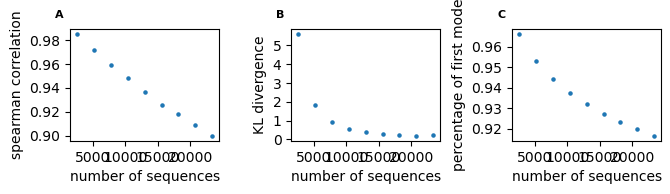

In [14]:
result = np.array(result)

fig = plt.figure(figsize=(6.75,6.75*0.3),facecolor="white",)
gs = fig.add_gridspec(1, 3)
axes = [fig.add_subplot(gs[i]) for i in range(3)]
plt.rcParams.update({'font.size': 8})
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)
fig.canvas.draw()

for n, ax in enumerate(axes):
  ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes,
            size=8, weight='bold')

axes[0].scatter(result[:,0],result[:,1],s=5)
axes[0].set_xlabel("number of sequences")
axes[0].set_ylabel("spearman correlation")

axes[1].scatter(result[:,0],result[:,2], s=5)
axes[1].set_xlabel("number of sequences")
axes[1].set_ylabel("KL divergence")


axes[2].scatter(result[:,0],result[:,3], s=5)
axes[2].set_xlabel("number of sequences")
axes[2].set_ylabel("percentage of first mode")


plt.tight_layout()
plt.savefig("APC_signal.pdf")

In [39]:
# split the training set and test set into 80%:20%
shuffle_idx = np.random.permutation(np.arange(N))
N_cut = int(0.8*N)
train_idx = shuffle_idx[:N_cut]
test_idx = shuffle_idx[N_cut:]
print(f"There are {N_cut} sequences are alloquated in training set, and rest in testing set")

There are 20757 sequences are alloquated in training set, and rest in testing set


In [40]:
def generate_msa_null(msa,nn=False):
  ## generate a negative sample with same pssm but no coevolution
  msa_null = []
  alphabet = np.arange(A)
  for n in range(L):
    a = alphabet
    p = np.mean(msa,0)[n]
    if nn:
      c = np.random.choice(a,N)
    else:
      c = np.random.choice(a,N,p=p)
    msa_null.append(c)
  msa_null = np.array(msa_null).T
  # msa_null = tf.keras.utils.to_categorical(msa_null,A)
  msa_null = jax.nn.one_hot(msa_null, num_classes=A)
  return msa_null
msa_null = generate_msa_null(msa[train_idx])
msa_null_null = generate_msa_null(msa[train_idx],nn=True)

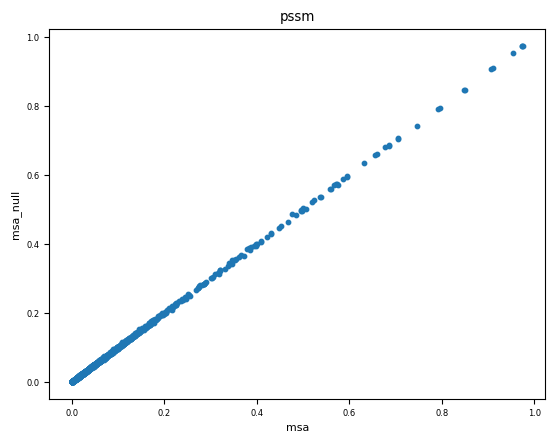

In [17]:
## check pssm is the same with real msa
plt.scatter(np.mean(msa,0),np.mean(msa_null,0),s=10)
plt.xlabel("msa")
plt.ylabel("msa_null")
plt.title("pssm")
plt.show()

In [18]:
train_idx = shuffle_idx[:5000]

In [19]:
###L2
V_L2,W_L2 = GREMLIN(msa_ori[train_idx],reg_mode="L2",param_flag=True)

In [20]:
Train_Loss_L2 = get_Hamiltonian_loss(msa[train_idx],W_L2,V_L2)
Test_Loss_L2 = get_Hamiltonian_loss(msa[test_idx],W_L2,V_L2)
Null_Loss_L2 = get_Hamiltonian_loss(msa_null,W_L2,V_L2)
Null_null_Loss_L2 = get_Hamiltonian_loss(msa_null_null,W_L2,V_L2)

In [21]:
###LH
V_LH,W_LH = GREMLIN(msa_ori[train_idx],reg_mode="LH",param_flag=True)

In [22]:
Train_Loss_LH = get_Hamiltonian_loss(msa[train_idx],W_LH,V_LH)
Test_Loss_LH = get_Hamiltonian_loss(msa[test_idx],W_LH,V_LH)
Null_Loss_LH = get_Hamiltonian_loss(msa_null,W_LH,V_LH)
Null_null_Loss_LH = get_Hamiltonian_loss(msa_null_null,W_LH,V_LH)

In [23]:
###block L1(LB)
V_LB,W_LB = GREMLIN(msa_ori[train_idx],reg_mode="LB",param_flag=True,Inv_init=False)

In [24]:
Train_Loss_LB = get_Hamiltonian_loss(msa[train_idx],W_LB,V_LB)
Test_Loss_LB = get_Hamiltonian_loss(msa[test_idx],W_LB,V_LB)
Null_Loss_LB = get_Hamiltonian_loss(msa_null,W_LB,V_LB)
Null_null_Loss_LB = get_Hamiltonian_loss(msa_null_null,W_LB,V_LB)

## Gradient differences

In [25]:
L2_performance = GREMLIN(msa_ori[train_idx],reg_mode="L2",param_flag=True,monitering=True,verbose=True,opt_iter=100)
LH_performance = GREMLIN(msa_ori[train_idx],reg_mode="LH",param_flag=True,monitering=True,verbose=True,opt_iter=100)
LB_performance = GREMLIN(msa_ori[train_idx],reg_mode="LB",param_flag=True,monitering=True,verbose=True,opt_iter=100)

iter full_loss,regularizer 20 225.38477 67.75903
iter full_loss,regularizer 40 221.32095 70.624146
iter full_loss,regularizer 60 218.80336 72.07155
iter full_loss,regularizer 80 217.43164 73.051476
iter full_loss,regularizer 100 216.12622 73.75712
iter full_loss,regularizer 20 263.6173 90.60434
iter full_loss,regularizer 40 257.33032 81.609695
iter full_loss,regularizer 60 253.8349 77.203064
iter full_loss,regularizer 80 251.56813 74.576096
iter full_loss,regularizer 100 250.2732 73.21092
iter full_loss,regularizer 20 243.78827 85.04965
iter full_loss,regularizer 40 239.26337 87.2522
iter full_loss,regularizer 60 236.36227 88.4304
iter full_loss,regularizer 80 234.22574 89.07577
iter full_loss,regularizer 100 232.51913 89.63557


### summary

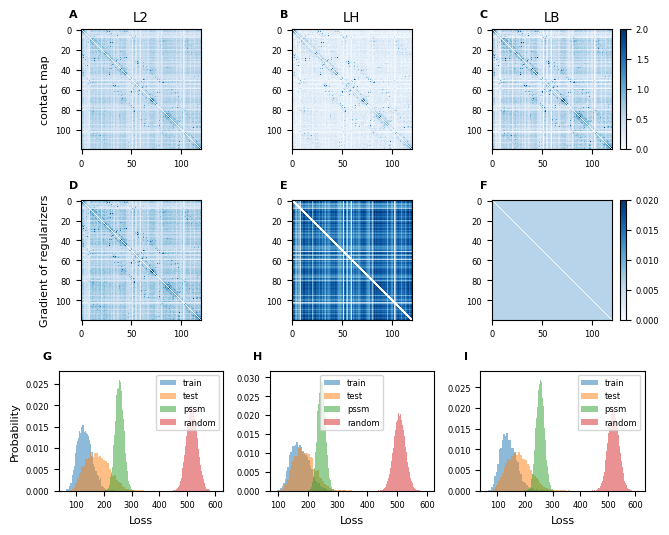

In [26]:
fig = plt.figure(figsize=(6.75,6.75*0.8),facecolor="white")
gs = fig.add_gridspec(3, 3)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for n, ax in enumerate(axes):
  ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes,
            size=8, weight='bold')

plt.rcParams.update({'font.size': 8})
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)
fig.canvas.draw()
#plt.subplot(331)
Gradient_M = L2_performance[99][3]
raw = L2_performance[99][1]
axes[0].set_title("L2")
axes[0].imshow(raw,vmin=0,vmax=2,cmap="Blues")
axes[0].set_ylabel("contact map")
#plt.colorbar()
#plt.subplot(334)
axes[3].imshow(Gradient_M,vmin=0,vmax=0.02,cmap="Blues")
axes[3].set_ylabel("Gradient of regularizers")
#plt.colorbar()
#plt.subplot(337)
axes[6].hist(Train_Loss_L2,bins=50,density=True,alpha=0.5,label="train")
axes[6].hist(Test_Loss_L2,bins=50,density=True,alpha=0.5,label="test")
axes[6].hist(Null_Loss_L2,bins=50,density=True,alpha=0.5,label="pssm")
axes[6].hist(Null_null_Loss_L2,bins=50,label="random",alpha=0.5,density=True)
#plt.xlabel("Hamiltonian")
axes[6].set_xlabel("Loss")
axes[6].set_ylabel("Probability")
axes[6].legend(prop={'size': 6})


#plt.subplot(332)
Gradient_M = LH_performance[99][3]
raw = LH_performance[99][1]
axes[1].set_title("LH")
axes[1].imshow(raw,vmin=0,vmax=2,cmap="Blues")
#plt.ylabel("M")
#plt.colorbar()
#plt.subplot(335)
axes[4].imshow(Gradient_M,vmin=0,vmax=0.02,cmap="Blues")
#plt.ylabel("Gradient of regularizers")
#plt.colorbar()
M, apc = get_mtx(W_LB)
#plt.subplot(338)

axes[7].hist(Train_Loss_LH,bins=50,density=True,alpha=0.5,label="train")
axes[7].hist(Test_Loss_LH,bins=50,density=True,alpha=0.5,label="test")
axes[7].hist(Null_Loss_LH,bins=50,density=True,alpha=0.5,label="pssm")
axes[7].hist(Null_null_Loss_LH,bins=50,label="random",alpha=0.5,density=True)
axes[7].set_xlabel("Loss")
#plt.ylabel("Probability")
axes[7].legend(prop={'size': 6})


Gradient_M = LB_performance[99][3]
raw = LB_performance[99][1]
axes[2].set_title("LB")
im2 = axes[2].imshow(raw,vmin=0,vmax=2,cmap="Blues")
#plt.ylabel("M")
fig.colorbar(im2,ax= axes[2])
#plt.subplot(336)
im5 = axes[5].imshow(Gradient_M,vmin=0,vmax=0.02,cmap="Blues")
#plt.ylabel("Gradient of regularizers")
fig.colorbar(im5,ax= axes[5])
#plt.subplot(339)
axes[8].hist(Train_Loss_LB,bins=50,density=True,alpha=0.5,label="train")
axes[8].hist(Test_Loss_LB,bins=50,density=True,alpha=0.5,label="test")
axes[8].hist(Null_Loss_LB,bins=50,density=True,alpha=0.5,label="pssm")
axes[8].hist(Null_null_Loss_LB,bins=50,label="random",alpha=0.5,density=True)
axes[8].set_xlabel("Loss")
##plt.ylabel("Probability")
axes[8].legend(prop={'size': 6})

plt.tight_layout()
plt.savefig("Figure2.pdf")

## Robustness

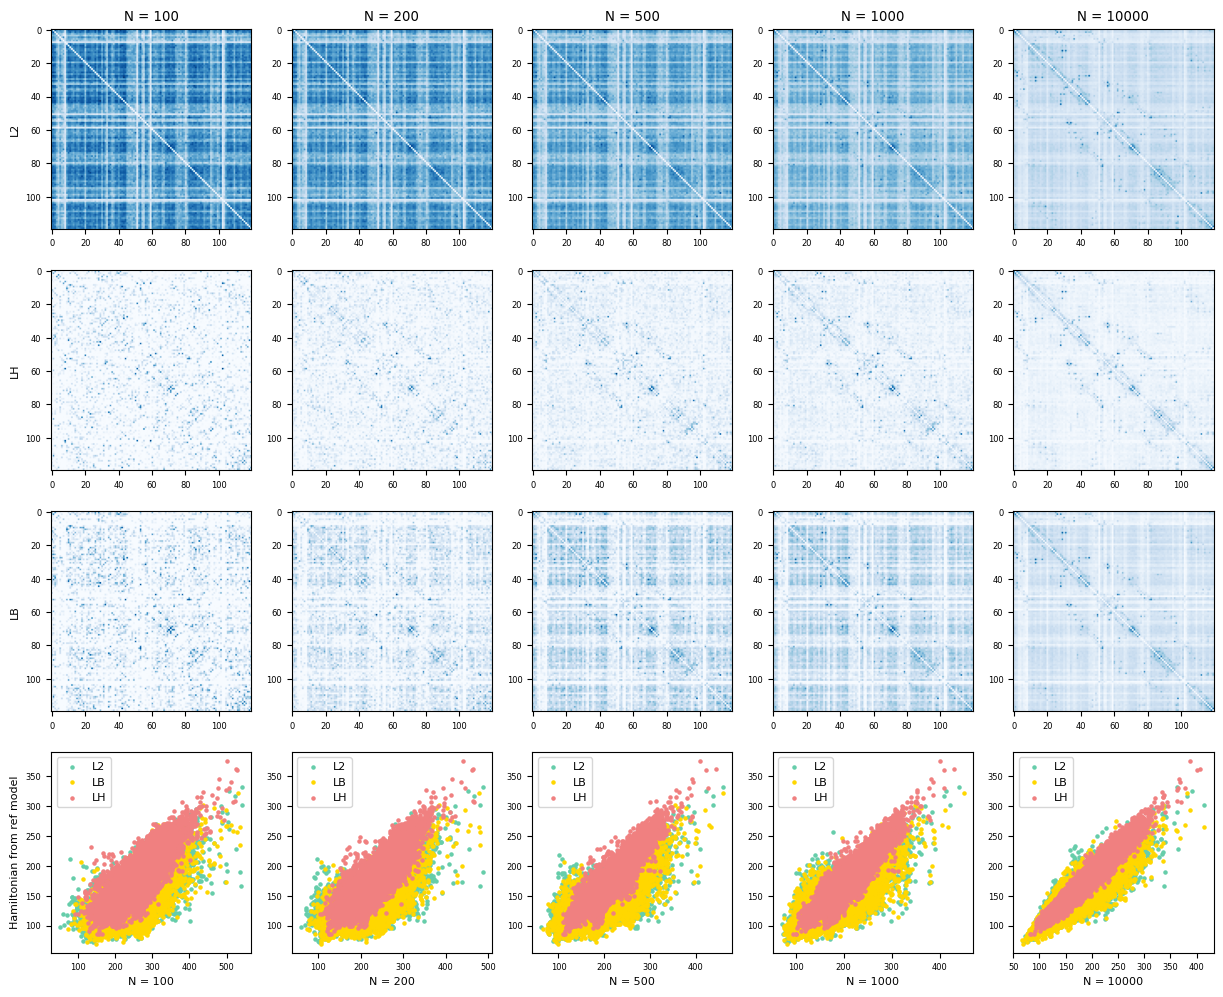

In [27]:
result = list()
result_kl = list()
(N,L,A) = msa.shape
plt.figure(figsize=(15,12),facecolor="white")

return_H = False
V_L2_ref,W_L2_ref = GREMLIN(msa_ori,reg_mode="L2",param_flag=True)
V_LH_ref,W_LH_ref = GREMLIN(msa_ori,reg_mode="LH",param_flag=True)
V_LB_ref,W_LB_ref = GREMLIN(msa_ori,reg_mode="LB",param_flag=True)

shuffle_idx = np.random.permutation(np.arange(N))
test_idx = shuffle_idx[10000:]

for n,i in  enumerate([100,200,500,1000,10000]):

  train_idx = shuffle_idx[:i]

  ####L2
  V_L2,W_L2 = GREMLIN(msa_ori[train_idx],reg_mode="L2",param_flag=True)
  Train_Loss_L2 = get_Hamiltonian_loss(msa[test_idx],W_L2,V_L2,return_H=return_H)
  Train_Loss_L2_ref = get_Hamiltonian_loss(msa[test_idx],W_L2_ref,V_L2_ref,return_H=return_H)

  ####LH
  V_LH,W_LH = GREMLIN(msa_ori[train_idx],reg_mode="LH",param_flag=True)
  Train_Loss_LH = get_Hamiltonian_loss(msa[test_idx],W_LH,V_LH,return_H=return_H)
  Train_Loss_LH_ref = get_Hamiltonian_loss(msa[test_idx],W_LH_ref,V_LH_ref,return_H=return_H)

  ####LB
  V_LB,W_LB = GREMLIN(msa_ori[train_idx],reg_mode="LB",param_flag=True)
  Train_Loss_LB = get_Hamiltonian_loss(msa[test_idx],W_LB,V_LB,return_H=return_H)
  Train_Loss_LB_ref = get_Hamiltonian_loss(msa[test_idx],W_LB_ref,V_LB_ref,return_H=return_H)


  plt.subplot(4,5,n+1)
  if n ==0:
    plt.ylabel("L2")
  plt.title(f"N = {i}")
  raw,apc = get_mtx(W_L2)
  plt.imshow(raw,cmap="Blues")
  plt.subplot(4,5,n+6)
  if n ==0:
    plt.ylabel("LH")
  raw,apc = get_mtx(W_LH)
  plt.imshow(raw,cmap="Blues")
  plt.subplot(4,5,n+11)
  if n ==0:
    plt.ylabel("LB")
  raw,apc = get_mtx(W_LB)
  plt.imshow(raw,cmap="Blues")

  plt.subplot(4,5,n+16)

  Test_Loss_L2 = get_Hamiltonian_loss(msa[test_idx],W_L2,V_L2,return_H=return_H)
  Test_Loss_L2_ref = get_Hamiltonian_loss(msa[test_idx],W_L2_ref,V_L2_ref,return_H=return_H)

  Test_Loss_LH = get_Hamiltonian_loss(msa[test_idx],W_LH,V_LH,return_H=return_H)
  Test_Loss_LH_ref = get_Hamiltonian_loss(msa[test_idx],W_LH_ref,V_LH_ref,return_H=return_H)

  Test_Loss_LB = get_Hamiltonian_loss(msa[test_idx],W_LB,V_LB,return_H=return_H)
  Test_Loss_LB_ref = get_Hamiltonian_loss(msa[test_idx],W_LB_ref,V_LB_ref,return_H=return_H)

  plt.scatter(Test_Loss_L2,Test_Loss_L2_ref,s=5,c="mediumaquamarine",label="L2")
  plt.scatter(Test_Loss_LB,Test_Loss_LB_ref,s=5,c="gold",label="LB")
  plt.scatter(Test_Loss_LH,Test_Loss_LH_ref,s=5,c="lightcoral",label="LH")

  if n ==0:
    plt.ylabel("Hamiltonian from ref model")
  plt.xlabel(f"N = {i}")
  plt.legend()


  result.append([i,Train_Loss_L2,Train_Loss_L2_ref,Train_Loss_LH,Train_Loss_LH_ref,Train_Loss_LB,Train_Loss_LB_ref])
  result_kl.append([i,
                    kl_divergence_gaussians(Test_Loss_L2,Train_Loss_L2),
                    kl_divergence_gaussians(Test_Loss_LH,Train_Loss_LH),
                    kl_divergence_gaussians(Test_Loss_LH,Train_Loss_LB)
                    ])

plt.savefig("Hamiltonian_sequence.pdf")

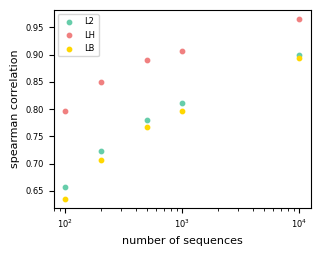

In [28]:
plt.figure(figsize=(3.25,3.25*0.8),facecolor="white")

plt.rcParams.update({'font.size': 8})
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)


tmp = []
for i in range(5):
  # try spearmanr next time
  tmp.append([result[i][0],
              scipy.stats.spearmanr(result[i][1],result[i][2])[0],
              scipy.stats.spearmanr(result[i][3],result[i][4])[0],
              scipy.stats.spearmanr(result[i][5],result[i][6])[0]])
tmp = np.array(tmp)
plt.scatter(tmp[:,0],tmp[:,1],c="mediumaquamarine",s=10,label="L2")
plt.scatter(tmp[:,0],tmp[:,2],c="lightcoral",s=10,label="LH")
plt.scatter(tmp[:,0],tmp[:,3],c="gold",s=10,label="LB")
plt.xticks(np.arange(5), [100,200,500,1000,10000])
plt.xscale("log")
plt.xlabel("number of sequences")
plt.ylabel("spearman correlation")
plt.legend(prop={'size': 6})
plt.tight_layout()
plt.savefig("spearman_sequence.pdf")

#### conclusion

from the pearson correlation side, we can see that the Hamiltonian term from low quality MSA is more correlated with the Hamiltonian term from the ref model, which means LH is better than L2 in ranking sequence energy. From the KL divergence side, this measurement showed the statistical distribution of training and test set, and we can see that LH has lower KL divergence compared to L2, which means the system is less overfitting!

### PCA analysis of W matrix
 show potential probability of encoding the pairwise pssm

In [29]:
MTX_LH = W_LH.transpose([0,2,1,3]).reshape(L*L,-1)
MTX_LB = W_LB.transpose([0,2,1,3]).reshape(L*L,-1)
MTX_L2 = W_L2.transpose([0,2,1,3]).reshape(L*L,-1)

In [30]:
tmp = np.ones((L,L))
tmp[np.tril_indices(L)] = 0
idx = np.where(tmp.flatten()==0)
MTX_top_LH = MTX_LH[idx]
MTX_top_LB = MTX_LB[idx]
MTX_top_L2 = MTX_L2[idx]

In [31]:
U_LH,S_LH = np.linalg.eigh(MTX_top_LH.T@MTX_top_LH)
U_L2,S_L2 = np.linalg.eigh(MTX_top_L2.T@MTX_top_L2)
U_LB,S_LB = np.linalg.eigh(MTX_top_LB.T@MTX_top_LB)

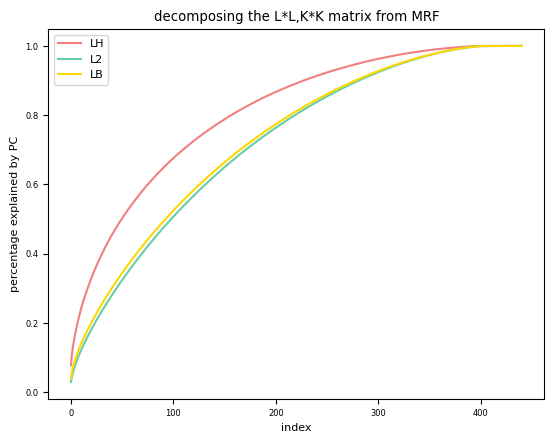

In [32]:
plt.figure(facecolor="white")
plt.plot(np.cumsum(U_LH[::-1])/np.sum(U_LH),c="lightcoral",label="LH")
plt.plot(np.cumsum(U_L2[::-1])/np.sum(U_L2),c="mediumaquamarine",label="L2")
plt.plot(np.cumsum(U_LB[::-1])/np.sum(U_LB),c="gold",label="LB")
plt.legend()
plt.xlabel("index")
plt.title("decomposing the L*L,K*K matrix from MRF")
plt.ylabel("percentage explained by PC")
plt.savefig("PCA.pdf")

### try more examples
9 different proteins with different number of sequences with be chosen.

In [33]:
#!wget -nc -q --no-check-certificate https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/3QHPA.fas
#!wget -nc -q --no-check-certificate https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/3OIOA.fas
#!wget -nc -q --no-check-certificate https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/3CNBA.fas
!wget -nc -q --no-check-certificate https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/5CYVA.fas
!wget -nc -q --no-check-certificate https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/3BDIA.fas
!wget -nc -q --no-check-certificate https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/2R1JL.fas
!wget -nc -q --no-check-certificate https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/2PR7A.fas
!wget -nc -q --no-check-certificate https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4WPGA.fas
!wget -nc -q --no-check-certificate https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/3RJUA.fas
!wget -nc -q --no-check-certificate https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/2HFSA.fas
!wget -nc -q --no-check-certificate https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/2H8GA.fas
!wget -nc -q --no-check-certificate https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/1ITVA.fas

In [34]:
name_list = ["5CYVA","3BDIA","2R1JL","2PR7A","4WPGA","3RJUA","2HFSA","2H8GA","1ITVA"]
protein_list = []
for name in name_list:
  msa_dict = {}
  ###making MSA
  names,seqs = parse_fasta(f"{name}.fas")
  msa_ori,msa = mk_msa(seqs)
  msa_dict["msa_ori"] = msa_ori
  #split training set and test set
  (N,L,A) = msa.shape
  shuffle_idx = np.random.permutation(np.arange(N))
  train_idx = shuffle_idx[:int(0.8*N)]
  test_idx = shuffle_idx[int(0.8*N):]
  # generating null sequence
  msa_null = generate_msa_null(msa[train_idx])
  msa_null_null = generate_msa_null(msa[train_idx],nn=True)

  #L2
  V_L2,W_L2 = GREMLIN(msa_ori[train_idx],reg_mode="L2",param_flag=True,verbose=True)
  Train_Loss_L2 = get_Hamiltonian_loss(msa[train_idx],W_L2,V_L2)
  Test_Loss_L2 = get_Hamiltonian_loss(msa[test_idx],W_L2,V_L2)
  Null_Loss_L2 = get_Hamiltonian_loss(msa_null,W_L2,V_L2)
  Null_null_Loss_L2 = get_Hamiltonian_loss(msa_null_null,W_L2,V_L2)
  msa_dict["Train_Loss_L2"] = Train_Loss_L2
  msa_dict["Test_Loss_L2"] = Test_Loss_L2
  msa_dict["Null_Loss_L2"] = Null_Loss_L2
  msa_dict["Null_null_Loss_L2"] = Null_null_Loss_L2

  raw, apc = get_mtx(W_L2)
  msa_dict["raw_L2"] = raw
  #LH
  V_LH,W_LH = GREMLIN(msa_ori[train_idx],reg_mode="LH",param_flag=True,verbose=True)
  Train_Loss_LH = get_Hamiltonian_loss(msa[train_idx],W_LH,V_LH)
  Test_Loss_LH = get_Hamiltonian_loss(msa[test_idx],W_LH,V_LH)
  Null_Loss_LH = get_Hamiltonian_loss(msa_null,W_LH,V_LH)
  Null_null_Loss_LH = get_Hamiltonian_loss(msa_null_null,W_LH,V_LH)

  msa_dict["Train_Loss_LH"] = Train_Loss_LH
  msa_dict["Test_Loss_LH"] = Test_Loss_LH
  msa_dict["Null_Loss_LH"] = Null_Loss_LH
  msa_dict["Null_null_Loss_LH"] = Null_null_Loss_LH
  raw, apc = get_mtx(W_LH)
  msa_dict["raw_LH"] = raw

  protein_list.append(msa_dict)

iter full_loss,regularizer 80 256.62396 71.94977
iter full_loss,regularizer 160 253.89285 72.27602
iter full_loss,regularizer 240 252.38696 72.312874
iter full_loss,regularizer 320 251.36127 72.29165
iter full_loss,regularizer 400 250.58614 72.23448
iter full_loss,regularizer 80 297.88956 84.78943
iter full_loss,regularizer 160 289.888 73.476364
iter full_loss,regularizer 240 287.14484 69.48338
iter full_loss,regularizer 320 285.5485 67.4962
iter full_loss,regularizer 400 284.53983 66.16965
iter full_loss,regularizer 80 346.34546 123.46953
iter full_loss,regularizer 160 340.8507 119.6615
iter full_loss,regularizer 240 337.65924 117.01407
iter full_loss,regularizer 320 335.41052 115.01781
iter full_loss,regularizer 400 333.73505 113.50902
iter full_loss,regularizer 80 412.6344 139.62854
iter full_loss,regularizer 160 394.38074 112.965836
iter full_loss,regularizer 240 388.45264 104.01085
iter full_loss,regularizer 320 385.41632 99.76816
iter full_loss,regularizer 400 383.49374 97.294
it

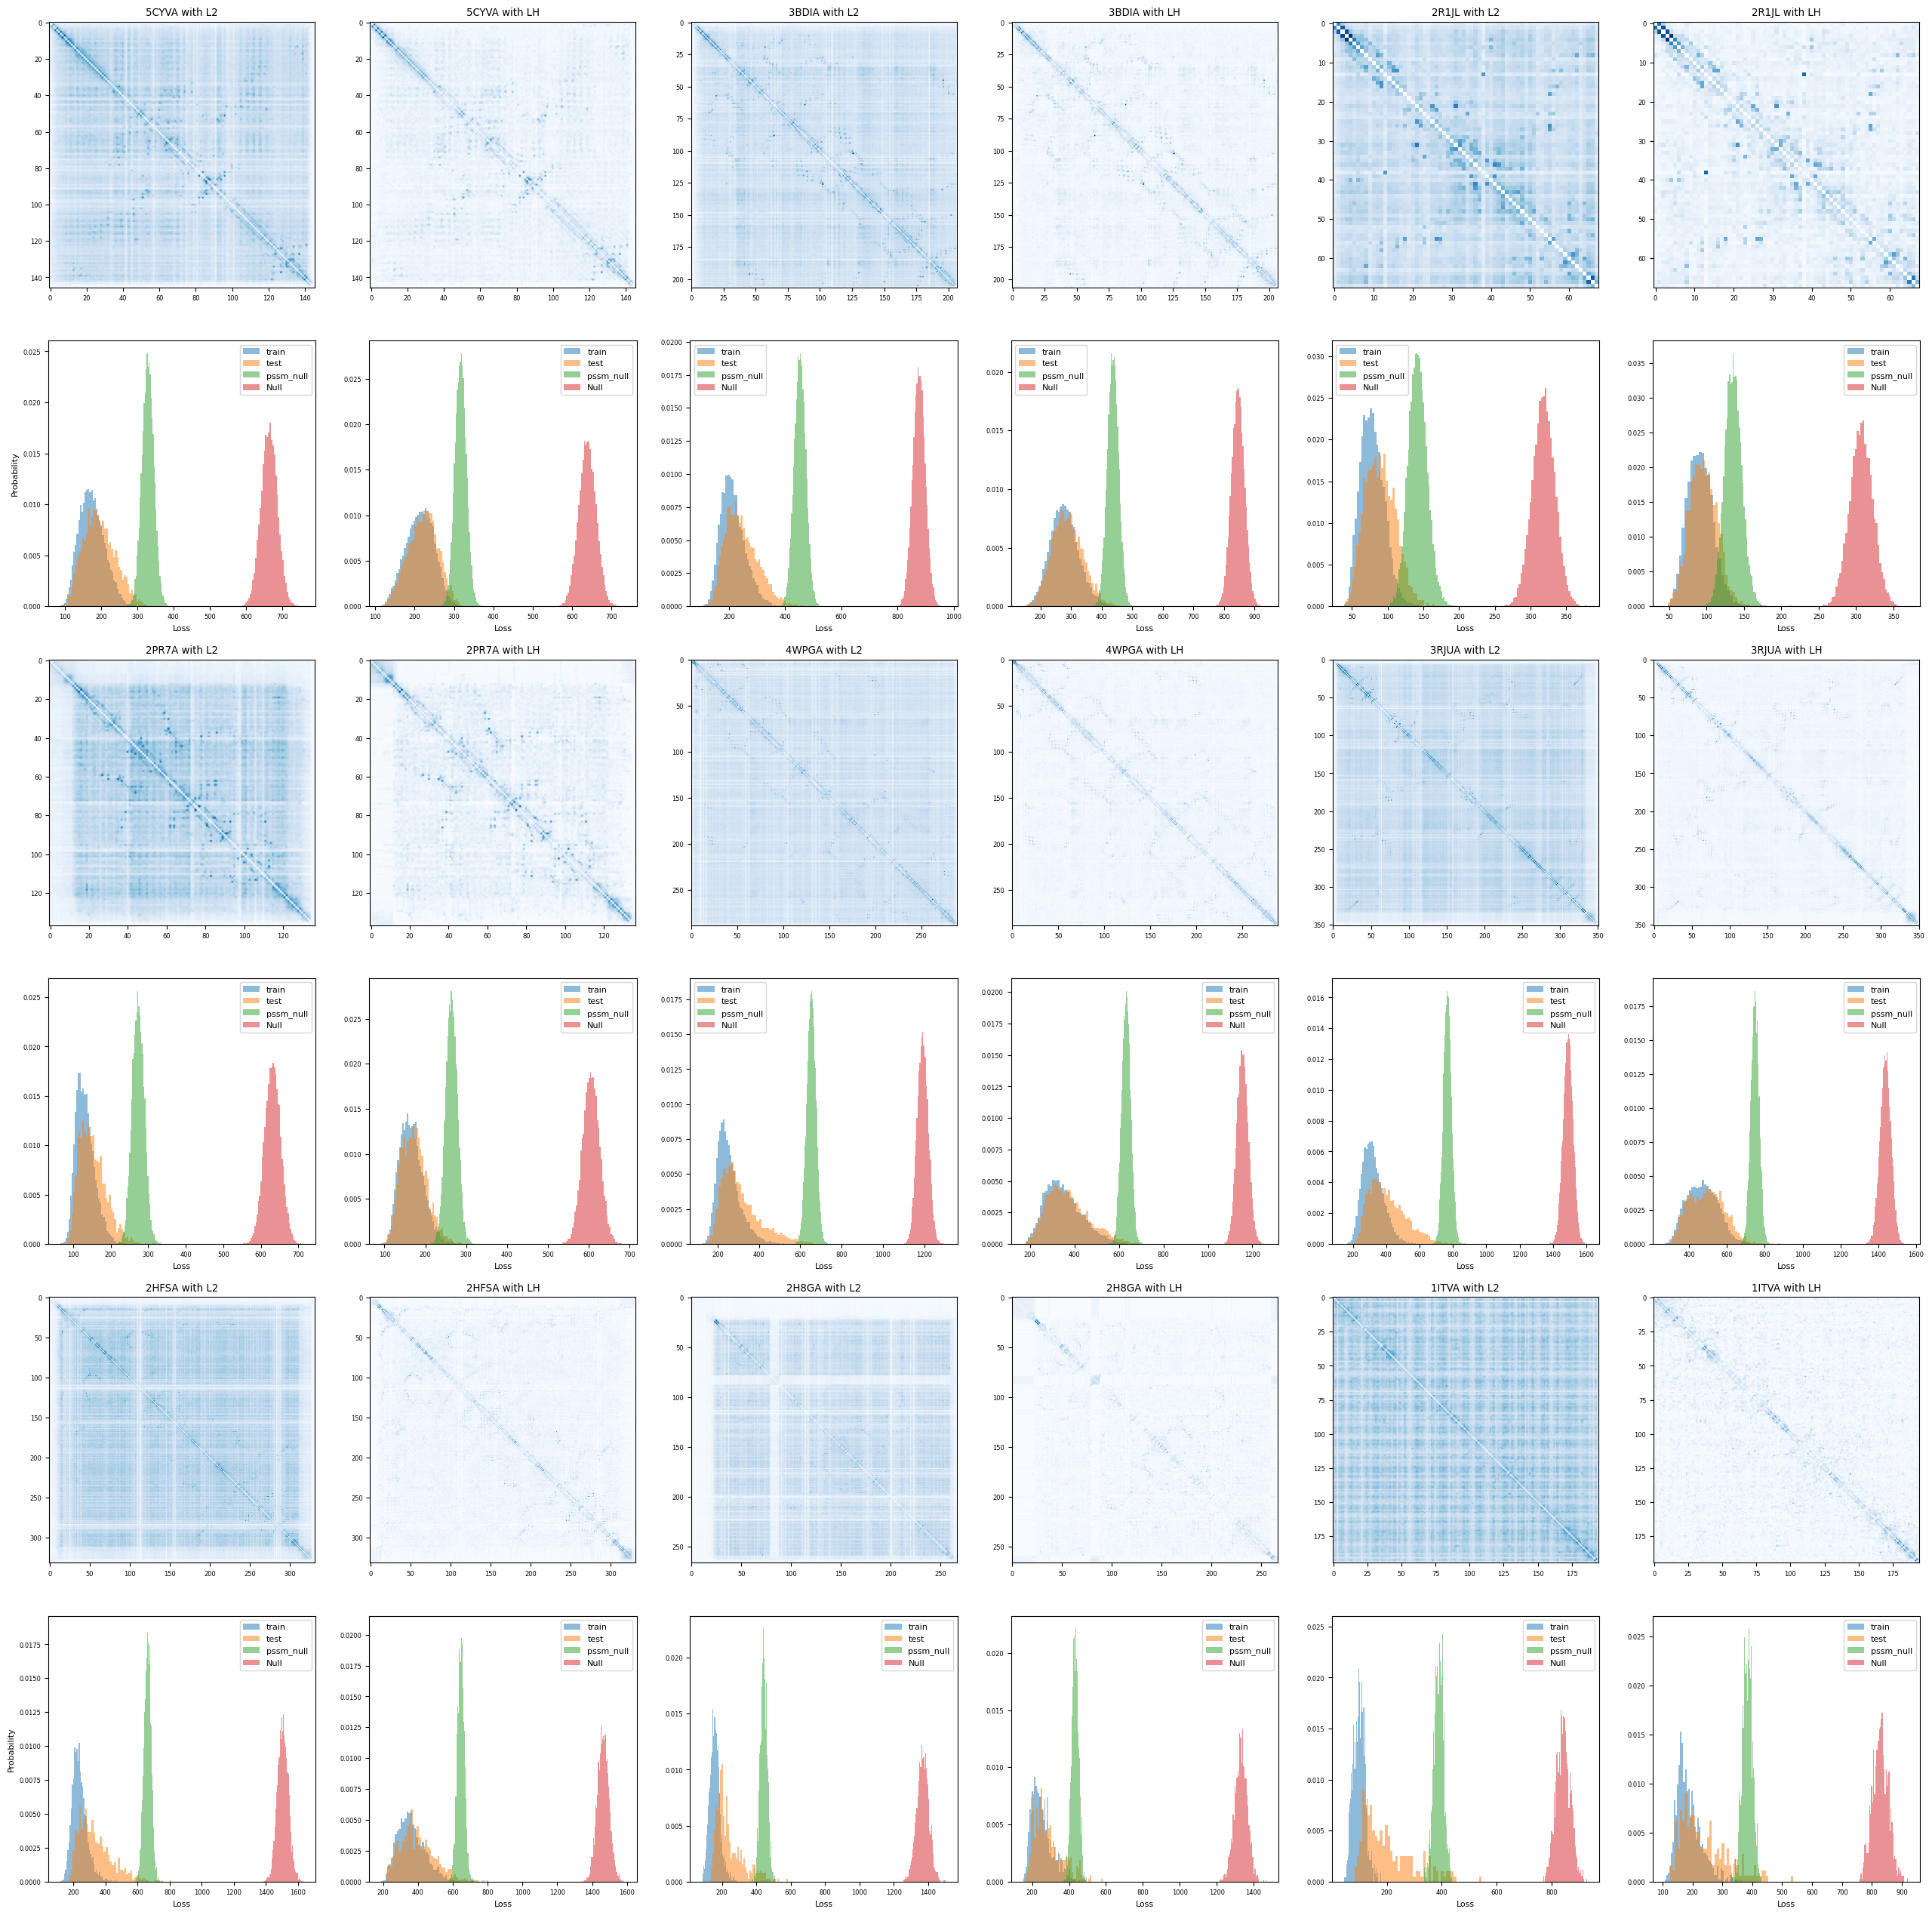

In [35]:
#fix the x and y axis
plt.figure(figsize=(32,32),facecolor="white")

for i,msa_dict in enumerate(protein_list):

  Train_Loss_L2 = msa_dict["Train_Loss_L2"]
  Test_Loss_L2 = msa_dict["Test_Loss_L2"]
  Null_Loss_L2 =msa_dict["Null_Loss_L2"]
  Null_null_Loss_L2 = msa_dict["Null_null_Loss_L2"]
  raw_L2 = msa_dict["raw_L2"]

  Train_Loss_LH = msa_dict["Train_Loss_LH"]
  Test_Loss_LH = msa_dict["Test_Loss_LH"]
  Null_Loss_LH =msa_dict["Null_Loss_LH"]
  Null_null_Loss_LH = msa_dict["Null_null_Loss_LH"]
  raw_LH = msa_dict["raw_LH"]

  plt.subplot(6,6,i*2+1 + 6*(i//3))
  plt.imshow(raw_L2,cmap="Blues")
  plt.grid(False)
  plt.title(f"{name_list[i]} with L2")
  plt.subplot(6,6,i*2+2+ 6*(i//3))
  plt.imshow(raw_LH,cmap="Blues")
  plt.grid(False)
  plt.title(f"{name_list[i]} with LH")
  plt.subplot(6,6,i*2+7+ 6*(i//3))
  #plt.title("L2")
  plt.xlabel("loss")
  if i%6==0:
    plt.ylabel("Probability")
  plt.hist(Train_Loss_L2,bins=50,density=True,alpha=0.5,label="train")
  plt.hist(Test_Loss_L2,bins=50,density=True,alpha=0.5,label="test")
  plt.hist(Null_Loss_L2,bins=50,density=True,alpha=0.5,label="pssm_null")
  plt.hist(Null_null_Loss_L2,bins=50,label="Null",alpha=0.5,density=True)
  plt.xlabel("Loss")
  plt.legend()
  plt.subplot(6,6,i*2+8+ 6*(i//3))
  #plt.title("LH")
  plt.hist(Train_Loss_LH,bins=50,density=True,alpha=0.5,label="train")
  plt.hist(Test_Loss_LH,bins=50,density=True,alpha=0.5,label="test")
  plt.hist(Null_Loss_LH,bins=50,density=True,alpha=0.5,label="pssm_null")
  plt.hist(Null_null_Loss_LH,bins=50,label="Null",alpha=0.5,density=True)
  plt.xlabel("Loss")
  plt.legend()

plt.savefig("SI-1.pdf")

## contact map
 this part takes some time to run, so I saved all the results in my google drive!

### load drive

In [ ]:
if os.getcwd()!="/home/whbpt/regal":
  from google.colab import drive
  drive.mount('/gdrive')
  os.chdir('/gdrive/My Drive')

In [36]:
!mkdir GREMLIN_LH
%cd GREMLIN_LH

/data/ruima/GREMLIN_LH/GREMLIN_LH


In [57]:
%%bash
wget -nc -q https://github.com/sokrypton/seqmodels/raw/master/data.pickle.npy.gz
if [ ! -f data.pickle.npy ];then
  gunzip data.pickle.npy.gz
fi

In [58]:
data = list(np.load("data.pickle.npy",allow_pickle=True))

In [59]:
def get_AUC(state_folder,data=data,redo=False):
  ACC_apc = []
  Ref_file = f"{state_folder}.pkl"
  if (not os.path.isfile(Ref_file) ) or redo :

    for n,a in enumerate(data):
      sub_ln = np.sum((np.sum(a["x_mask"],axis=-1) > 0))
      idx = np.triu_indices_from(a["x_true"],k=6)
      mask = np.where(a["x_mask"][idx] > 0)
      true = a["x_true"]
      try:
        acc_apc = []
        out_apc = f"{state_folder}/{a['x_id']}.raw"
        pred_apc = np.loadtxt(out_apc)

        acc_apc.append(get_acc(pred_apc[idx][mask],true[idx][mask],sub_ln))

        out_apc = f"{state_folder}/{a['x_id']}.apc"

        pred_apc2 = np.loadtxt(out_apc)
        acc_apc.append(get_acc(pred_apc2[idx][mask],true[idx][mask],sub_ln))

        ACC_apc.append(acc_apc)
      except IOError:
        continue
    ACC_apc = np.array(ACC_apc)
    #AUC_apc_approx = np.mean(ACC_apc,axis=(2))
    pickle.dump((ACC_apc),open(Ref_file,'wb'))
  else:
    ACC_apc = pickle.load(open(Ref_file,'rb'))
  return ACC_apc

def plot(AUC_apc_approx,figname= "LH"):
  f, ax = plt.subplots(2, 2,figsize=(13,12),facecolor="white")
  my_suptitle = f.suptitle(f"Performance comparision with L2/{figname}",y=0.95,fontsize=20)
  idx = AUC_apc_approx.shape[0]
  ax[0,0].plot( [0,1],[0,1], color="#007BA7")
  ax[0,0].scatter(AUC_ref[:idx,0],AUC_apc_approx[:,0],s=5)
  ax[0,0].set_xlabel("L2_raw",fontsize=14)
  ax[0,0].set_ylabel(f"{figname}_raw",fontsize=14)
  ax[0,0].tick_params(axis='both', which='major', labelsize=14)

  ax[0,1].plot( [0,1],[0,1], color="#007BA7")
  ax[0,1].scatter(AUC_ref[:idx,1],AUC_apc_approx[:,0],s=5)
  ax[0,1].set_xlabel("L2_apc",fontsize=14)
  ax[0,1].set_ylabel(f"{figname}_raw",fontsize=14)
  ax[0,1].tick_params(axis='both', which='major', labelsize=14)

  ax[1,0].plot( [0,1],[0,1], color="#007BA7")
  ax[1,0].scatter(AUC_ref[:idx,1],AUC_apc_approx[:,1],s=5)
  ax[1,0].set_xlabel("L2_apc",fontsize=14)
  ax[1,0].set_ylabel(f"{figname}_apc",fontsize=14)
  ax[1,0].tick_params(axis='both', which='major', labelsize=14)

  ax[1,1].plot( [0,1],[0,1], color="#007BA7")
  ax[1,1].scatter(AUC_apc_approx[:,0],AUC_apc_approx[:,1],s=5)
  ax[1,1].set_xlabel(f"{figname}_raw",fontsize=14)
  ax[1,1].set_ylabel(f"{figname}_apc",fontsize=14)
  ax[1,1].tick_params(axis='both', which='major', labelsize=14)
  f.savefig(f"{figname}.pdf",bbox_extra_artists=my_suptitle)
  plt.show()

In [60]:
#########################
# optional - remove positions > 50% gaps
#########################
rm_gaps = True
if rm_gaps:
  for a in data:
    gap_chk = (1 - (a["x"] == 20).mean(0)) > 0.5
    a["x"] = a["x"][:,gap_chk]
    a["x_mask"] = a["x_mask"][gap_chk,:][:,gap_chk]
    a["x_true"] = a["x_true"][gap_chk,:][:,gap_chk]

def get_acc(pred,true,sub_ln):
  pred_true = np.stack((pred,true),-1)
  pred_true = pred_true[pred_true[:,0].argsort()[::-1]]
  acc = []
  for n in range(10):
    N = int(sub_ln * (n+1)/10)
    acc.append(np.mean(pred_true[:N,1]))
  return np.array(acc)

### load ref L2

In [61]:
os.makedirs("ref_w_b", exist_ok=True)
for n,a in enumerate(data):
  out_raw = "ref_w_b/"+a["x_id"]+".raw"
  out_apc = "ref_w_b/"+a["x_id"]+".apc"
  if os.path.isfile(out_raw) == False or os.path.isfile(out_apc) == False:
    print(a["x_id"])
    raw_apc = GREMLIN(a["x"],use_bias = True,batch_size = 100,return_raw=True)
    np.savetxt(out_raw,raw_apc[0])
    np.savetxt(out_apc,raw_apc[1])

3A0YA
4ACIA
3AH7A
5A62A
2A4VA
1A3AA
3A35A
5A35A
3GM5A
2A67A
3A6SA
1NNHA
4A7UA
4A7WA
5ECCA
5A89A
5C0PA
2ABWA
2A9SA
4JS8A
3AABA
3AAYA
4C5KA
4ABLA
3ACXA
1AE9A
4AFFA
4AFHA
3AGYA
1M2KA
4AIVA
4AIWA
1AKOA
3AK8A
3AKBA
3ALUA
2AMHA
2AN1A
2ANRA
2ANXA
4WTPA
2APJA
2FBNA
4APXB
2AQ6A
1ATZA
4ATEA
4AVRA
3AWUA
4AY0A
2B0AA
1EUWA
4LSCA
5B3PA
2B5GA
2HQSC
3B8BA
4B8EA
2B94A
1BD8A
3BEDA
3BEMA
3SY1A
2BFWA
5C1EA
4BH5A
2C2IA
2BK8A
2BKMA
2BKXA
4LXQA
3BM7A
2BOUA
3BP3A
3BPKA
5C90A
3KG9A
3BR8A
3BT5A
1BUOA
2BV5A
3BWUD
3BWUF
1I4JA
1BXYA
1BYRA
3BY8A
5BY4A
2BZ1A
4N0KA
3C1QA
4C24A
3C37A
3C4BA
2C5QA
4C6AA
4C6SA
2C71A
2C8MA
2C92A
1K7KA
5CAJA
3CCDA
3CCGA
5CEGB
1WPNA
1CFBA
1CHDA
2GGCA
3CH0A
3LULA
3MN2A
4EWFA
3NREA
3CI3A
4NNOA
3CNVA
2EGZA
1COJA
1COZA
3CQ1A
5CQXA
1KQPA
1CTFA
1CUKA
2CVEA
1CXQA
3LF5A
3CXKA
5CX7A
3CZXA
1D0QA
3D01A
3D03A
4D05A
4D74A
4DBFA
2D4XA
3LTJA
4DAMA
3DBOB
3DD6A
1H72C
4DE9A
1DFUP
3DFGA
1DJ0A
2DQWA
3FDJA
2DTJA
4DT4A
4DUNA
2DXAA
4XTVA
2DYIA
2DYJA
2E0NA
2E11A
1K7JA
4E3YA
3UF6A
1E58A
2E5YA
2GUIA
2EBJA
3EERA
4HOI

In [62]:
Ref_file = f"AUC_ref.pkl"
if (not os.path.isfile(Ref_file) ) or False: # manually change this to True to rerun
  ACC_ref = []
  for n,a in enumerate(data):
    sub_ln = np.sum((np.sum(a["x_mask"],axis=-1) > 0))
    idx = np.triu_indices_from(a["x_true"],k=6)
    mask = np.where(a["x_mask"][idx] > 0)
    true = a["x_true"]

    acc = []

    out_raw = f"ref_w_b/{a['x_id']}.raw"
    pred_raw = np.loadtxt(out_raw)

    acc.append(get_acc(pred_raw[idx][mask],true[idx][mask],sub_ln))

    out_apc = f"ref_w_b/{a['x_id']}.apc"

    pred_apc = np.loadtxt(out_apc)
    acc.append(get_acc(pred_apc[idx][mask],true[idx][mask],sub_ln))

    ACC_ref.append(acc)


  ACC_ref = np.array(ACC_ref)
  AUC_ref = np.mean(ACC_ref,axis=(2))

  pickle.dump((ACC_ref,AUC_ref),open(Ref_file,'wb'))
else:
  ACC_ref,AUC_ref = pickle.load(open(Ref_file,'rb'))

### LH reg


In [63]:
reg_mode = "LH"
os.makedirs(reg_mode, exist_ok=True)

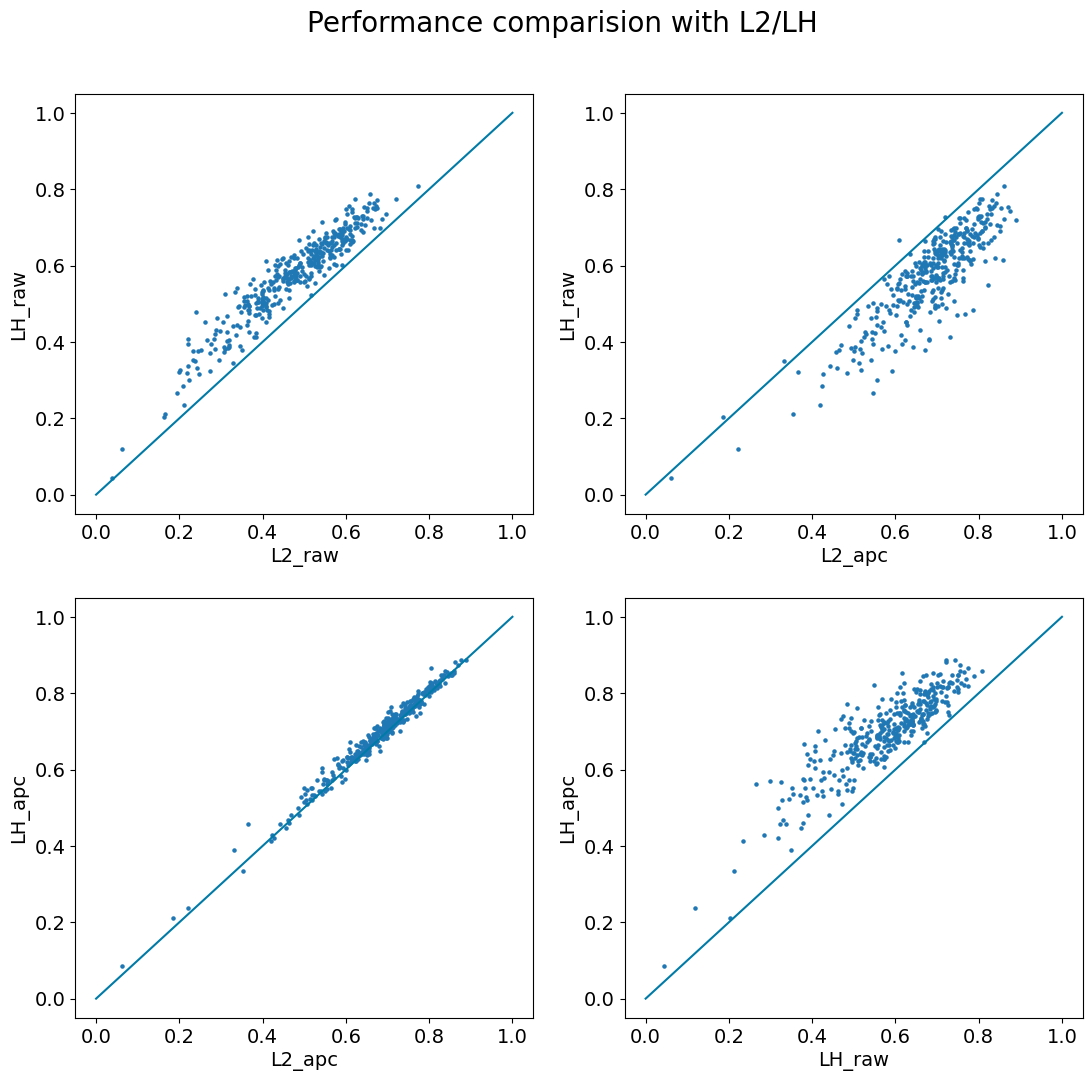

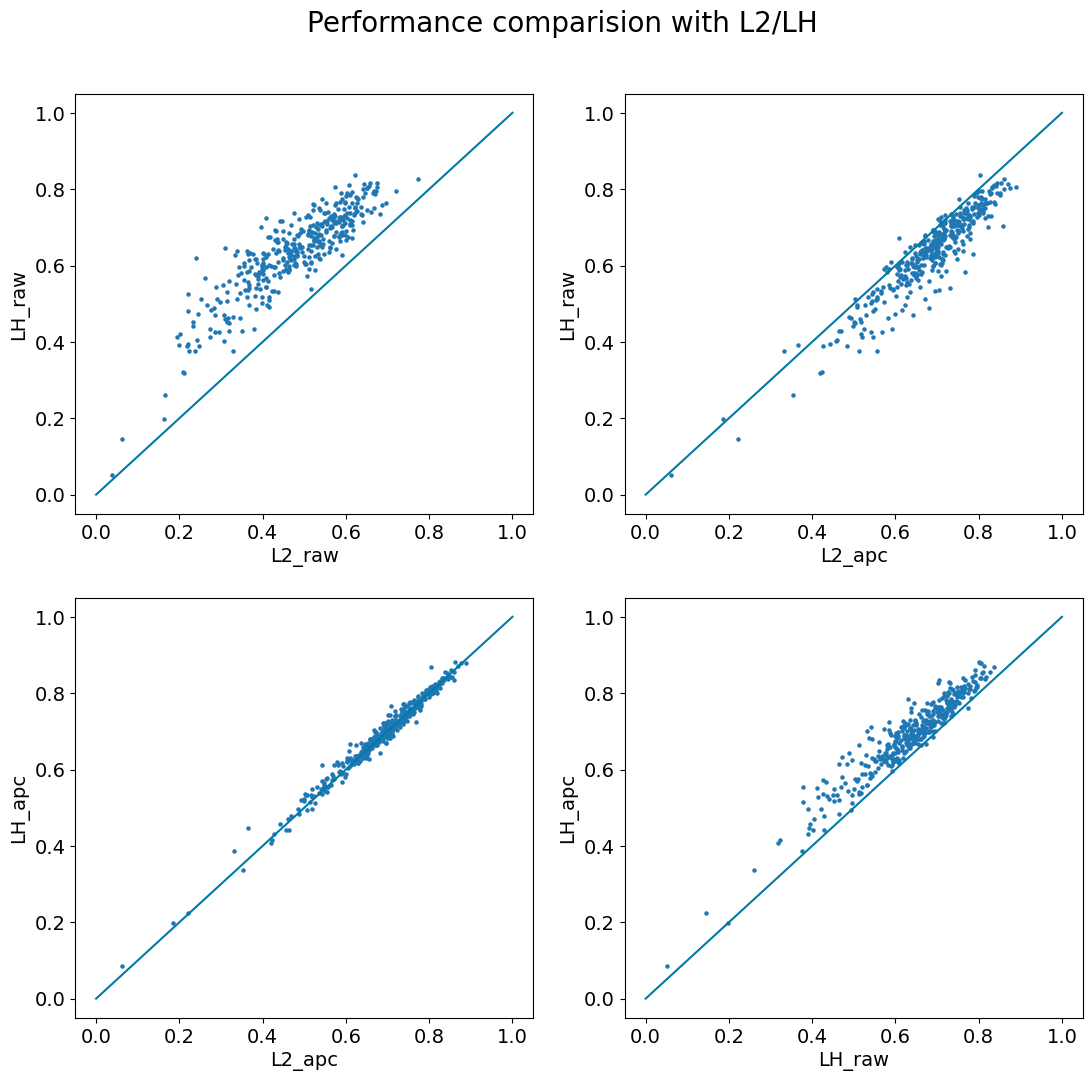

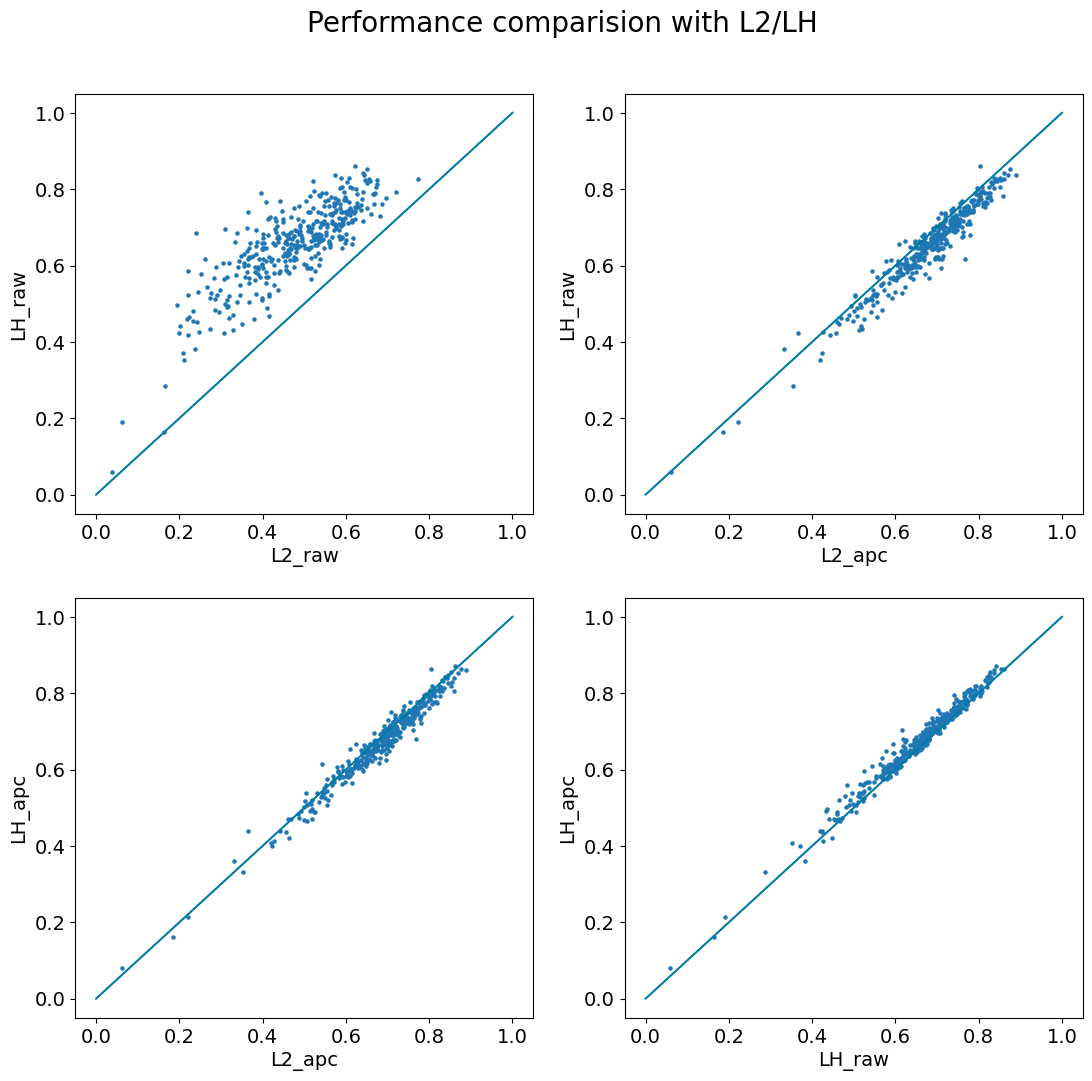

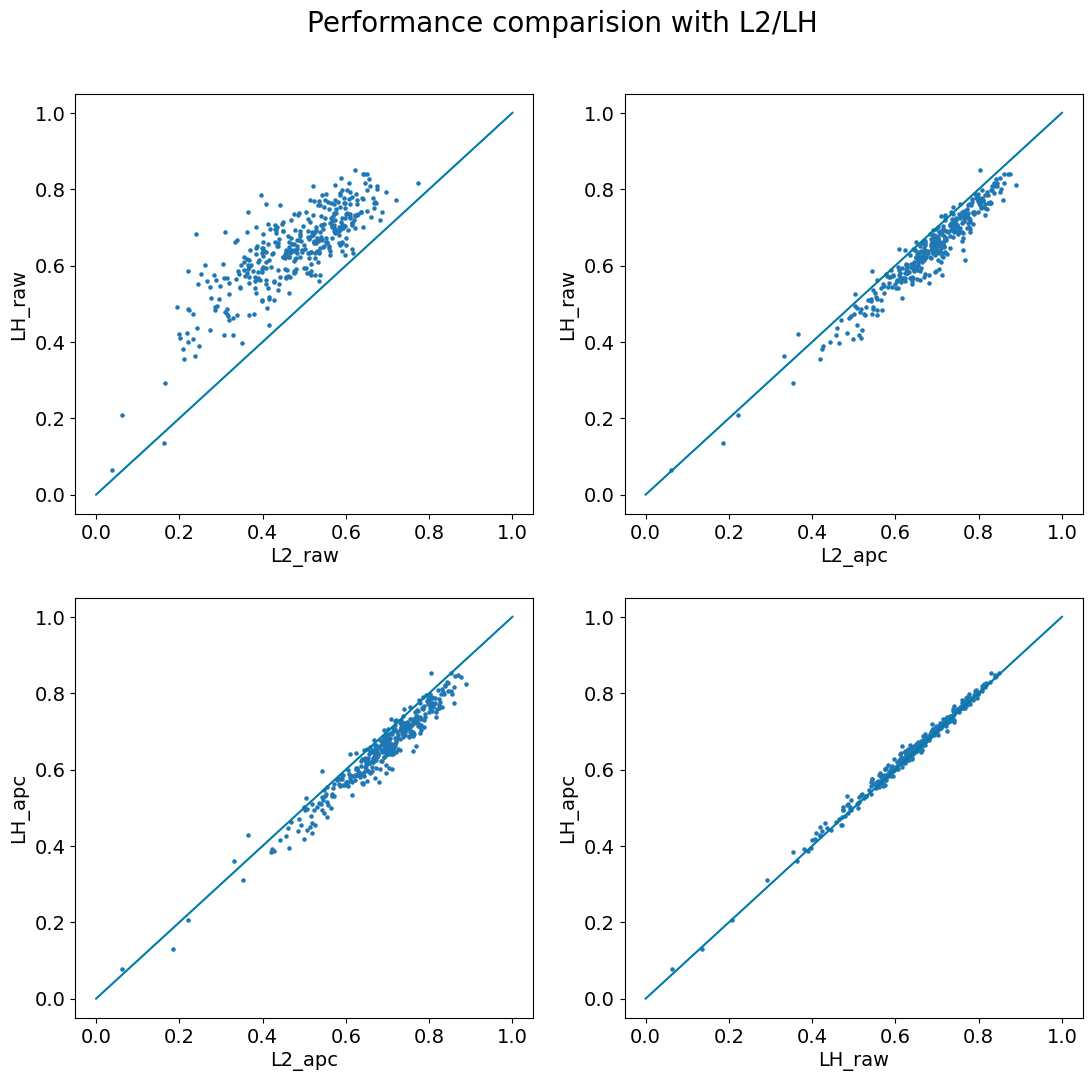

In [64]:
test_data = data[:]
lambda_list = [0.01,0.02,0.05,0.1,]
for lambda_LH in lambda_list:
  state_folder = f"{reg_mode}/encoder_ref_{lambda_LH}"
  !mkdir $state_folder
  for n,a in enumerate(test_data):
    #print(a["x_id"],lambda_LH)
    out_raw = f"{state_folder}/"+a["x_id"]+".raw"
    out_apc = f"{state_folder}/"+a["x_id"]+".apc"
    if os.path.isfile(out_apc) == False:
      raw_apc  = GREMLIN(a["x"],
                          opt_iter = 400,
                          batch_size = 100,
                          reg_mode = reg_mode,
                          power_iter = True,
                          Inv_init = True,
                          lambda_LH = lambda_LH,
                          return_raw = True)

      np.savetxt(out_raw,raw_apc[0])
      np.savetxt(out_apc,raw_apc[1])
  ACC = get_AUC(state_folder,data=test_data,redo=False)
  plot(np.mean(ACC,axis=(2)),figname=reg_mode)

In [65]:
performance_LH = list()
#lambda_list = [0.01,0.02,0.05,0.08,0.1,0.2,]
for lambda_LH in lambda_list:
  state_folder = f"{reg_mode}/encoder_ref_{lambda_LH}"
  ACC = get_AUC(state_folder,data=test_data,redo=False)
  AUC_LH =  np.mean(ACC,axis=(2))
  performance_LH.append([*AUC_LH.mean(0),lambda_LH])
performance_LH = np.array(performance_LH)

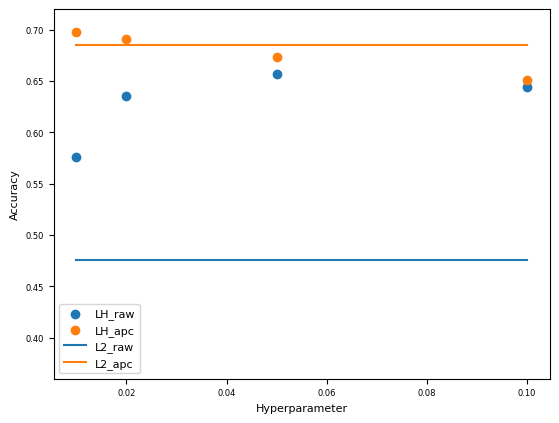

In [66]:
plt.figure(facecolor="white")
plt.scatter(performance_LH[:,2],performance_LH[:,0],label="LH_raw")
plt.scatter(performance_LH[:,2],performance_LH[:,1],label="LH_apc")
vmin = np.min(lambda_list)
vmax = np.max(lambda_list)
plt.plot([vmin,vmax],[AUC_ref.mean(0)[0],AUC_ref.mean(0)[0]],label="L2_raw")
plt.plot([vmin,vmax],[AUC_ref.mean(0)[1],AUC_ref.mean(0)[1]],label="L2_apc")
plt.xlabel("Hyperparameter")
plt.ylabel("Accuracy")
plt.ylim(0.36,0.72)
plt.legend()
plt.savefig("Fig2-2.pdf")

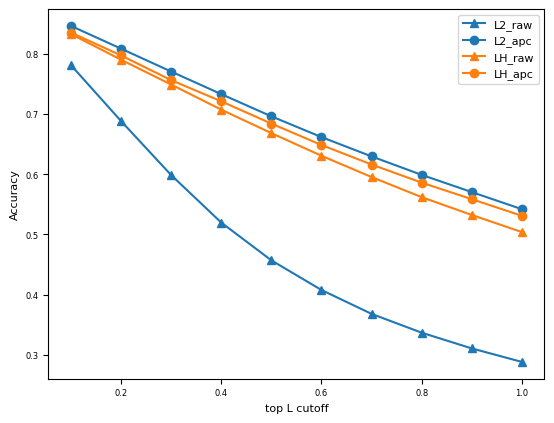

In [67]:
state_folder = f"{reg_mode}/encoder_ref_0.05" # best LH_apc performance
ACC = get_AUC(state_folder,data=test_data,redo=False)
Cutoff_LH = np.mean(ACC,0)

ACC = get_AUC("ref_w_b",data=test_data,redo=False)
Cutoff_ref = np.mean(ACC,0)

plt.plot(facecolor="white",dpi=300)
plt.plot(np.arange(1,11)*0.1,Cutoff_ref[0],"C0^-",label="L2_raw")
plt.plot(np.arange(1,11)*0.1,Cutoff_ref[1],"C0o-",label="L2_apc")
plt.plot(np.arange(1,11)*0.1,Cutoff_LH[0],"C1^-",label="LH_raw")
plt.plot(np.arange(1,11)*0.1,Cutoff_LH[1],"C1o-",label="LH_apc")
plt.xlabel("top L cutoff")
plt.ylabel("Accuracy")

plt.legend()
plt.savefig("Fig2-3.pdf")

In [68]:
performance = list()
AUC_ref = get_AUC("AUC_ref",data=test_data,redo=False)[1]
lambda_list = [0.05,]
for lambda_LH in lambda_list:
  state_folder = f"{reg_mode}/encoder_ref_{lambda_LH}"
  AUC_LH = get_AUC(state_folder,data=test_data,redo=False)[1]
  performance.append([*AUC_LH.mean(0),lambda_LH])
performance = np.array(performance)

### LB reg

In [69]:
reg_mode = "LB"
os.makedirs(reg_mode, exist_ok=True)

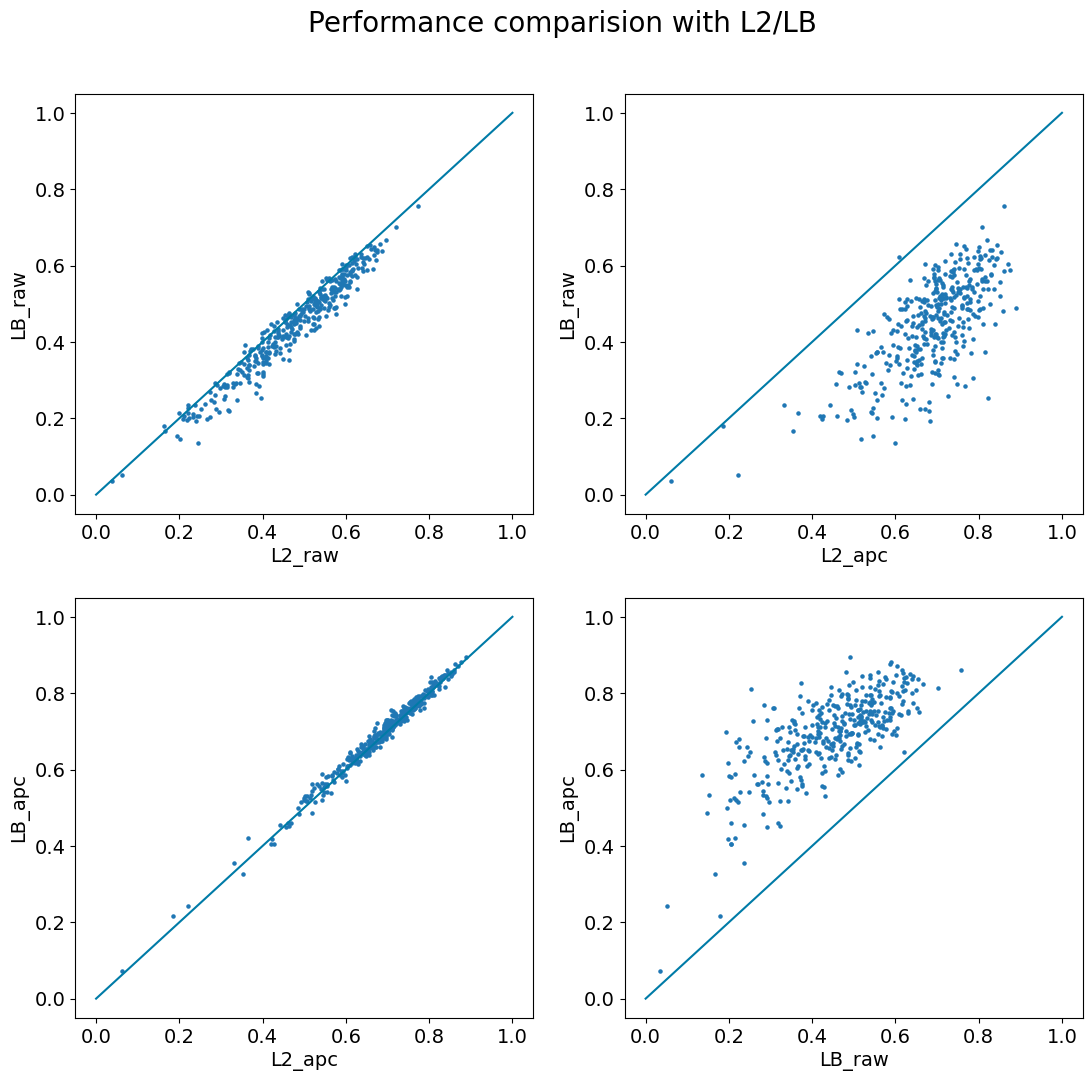

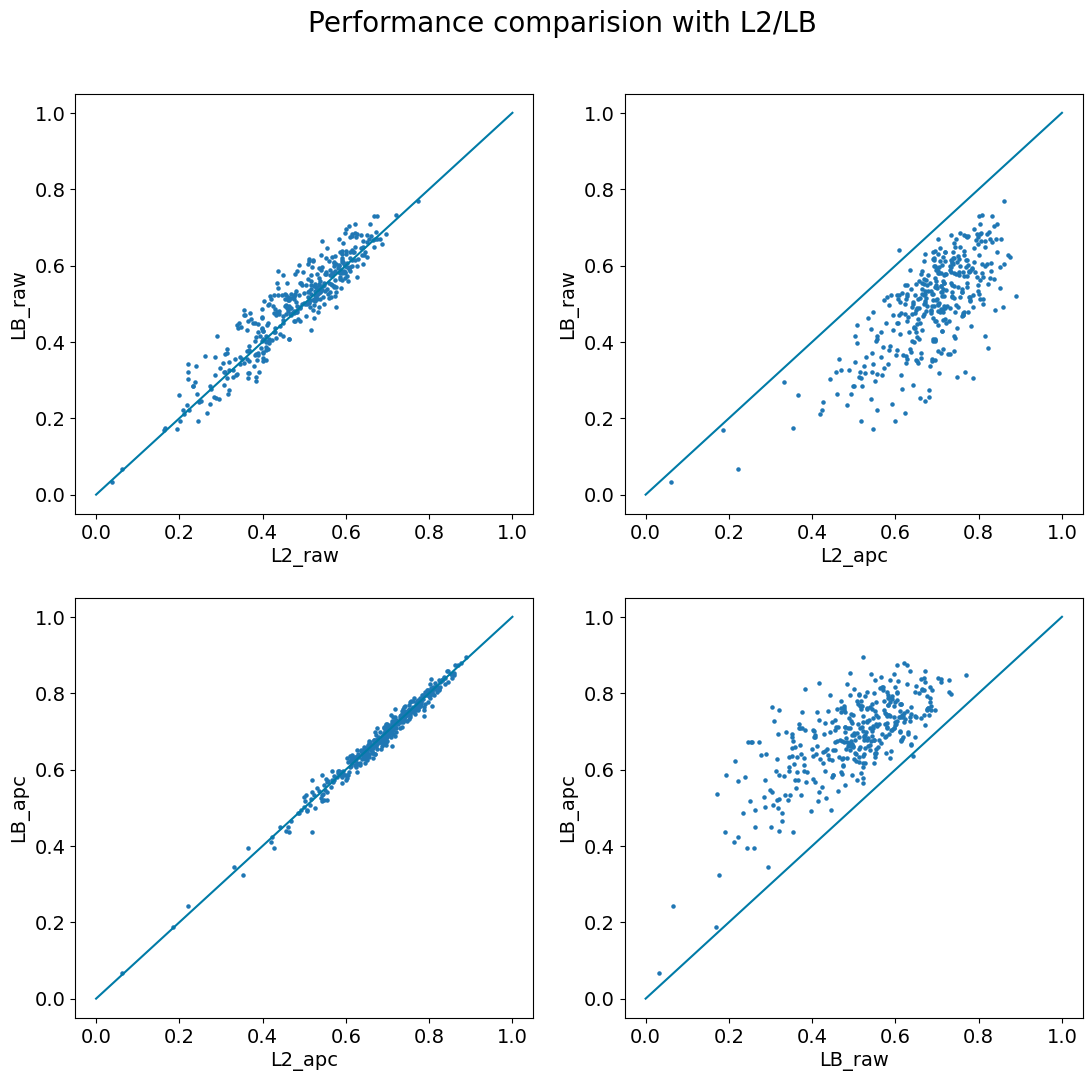

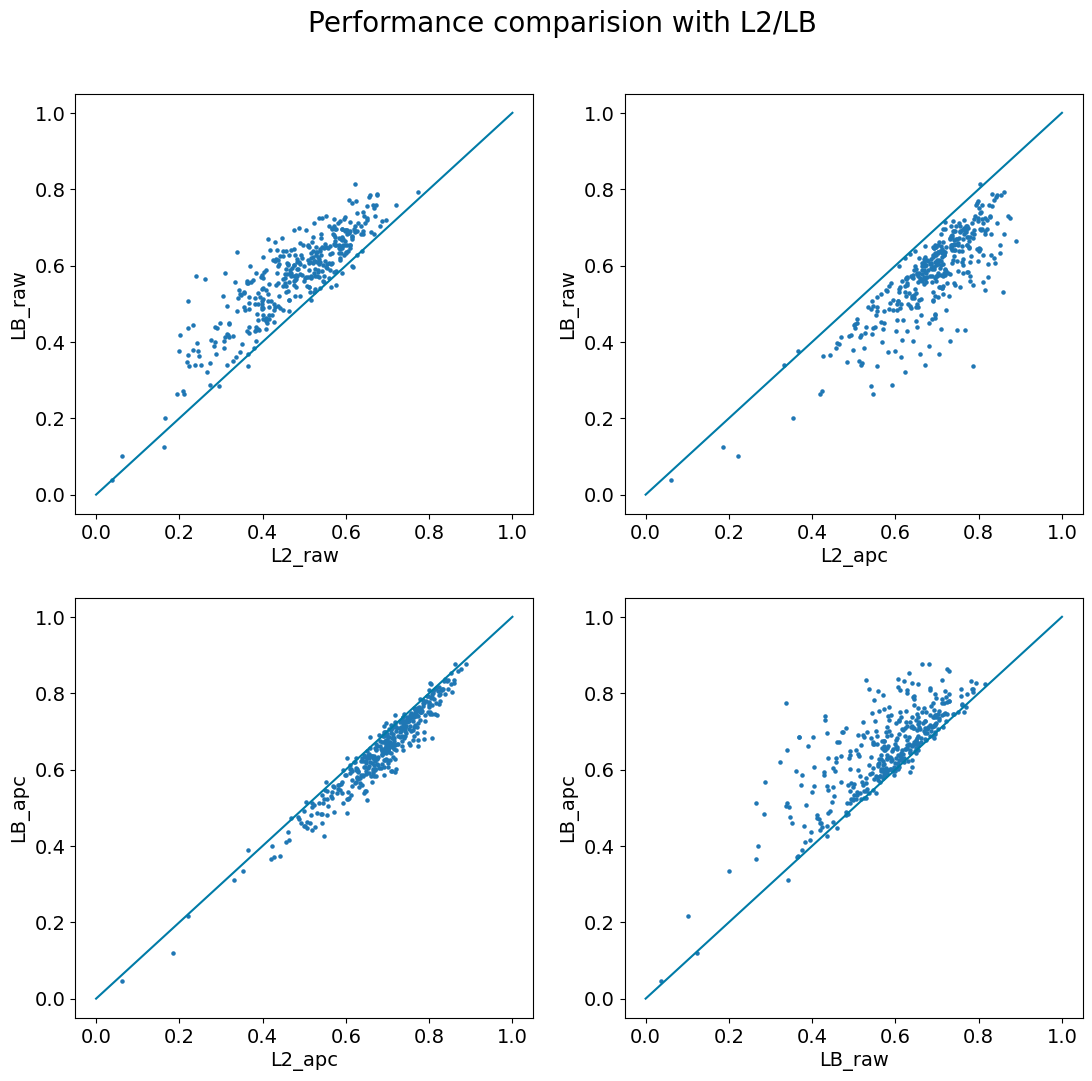

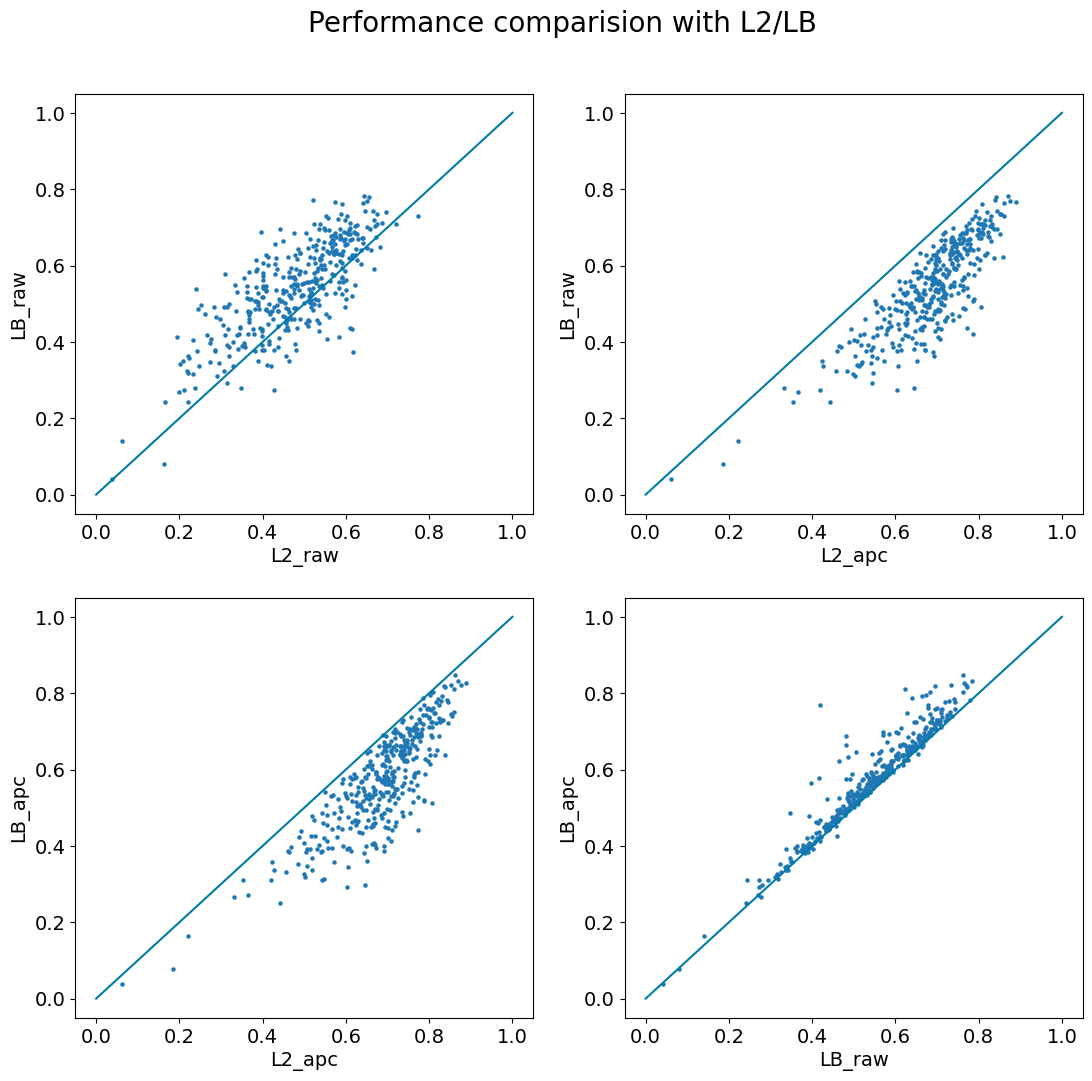

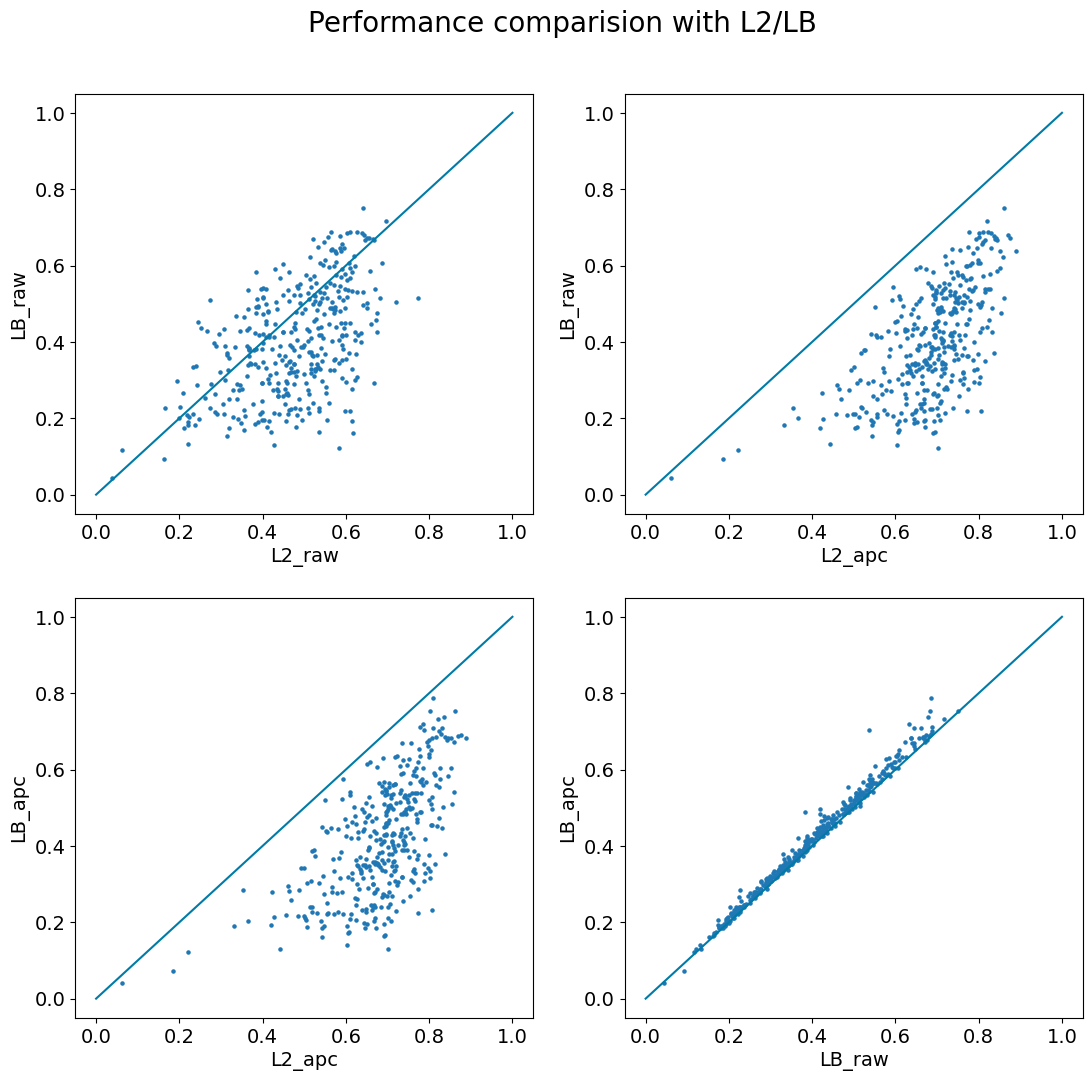

In [70]:
test_data = data[:]
lambda_list = [0.001,0.002,0.005,0.01,0.02,]
for lambda_LB in lambda_list:
  state_folder = f"{reg_mode}/encoder_ref_{lambda_LB}"
  !mkdir $state_folder
  for n,a in enumerate(test_data):
    #print(a["x_id"],lambda_LH)
    out_raw = f"{state_folder}/"+a["x_id"]+".raw"
    out_apc = f"{state_folder}/"+a["x_id"]+".apc"
    if os.path.isfile(out_apc) == False:
      raw_apc  = GREMLIN(a["x"],
                          opt_iter = 400,
                          batch_size = 100,
                          reg_mode = reg_mode,
                          power_iter = True,
                          Inv_init = False,
                          lambda_LB = lambda_LB,
                          return_raw = True)

      np.savetxt(out_raw,raw_apc[0])
      np.savetxt(out_apc,raw_apc[1])
  ACC = get_AUC(state_folder,data=test_data,redo=False)
  plot(np.mean(ACC,axis=(2)),figname=reg_mode)

In [71]:
performance_LB = list()
#lambda_list = [0.01,0.02,0.05,0.08,0.1,0.2,]
for lambda_LB in lambda_list:
  state_folder = f"{reg_mode}/encoder_ref_{lambda_LB}"
  ACC = get_AUC(state_folder,data=test_data,redo=False)
  AUC_LB =  np.mean(ACC,axis=(2))
  performance_LB.append([*AUC_LB.mean(0),lambda_LB])
performance_LB = np.array(performance_LB)

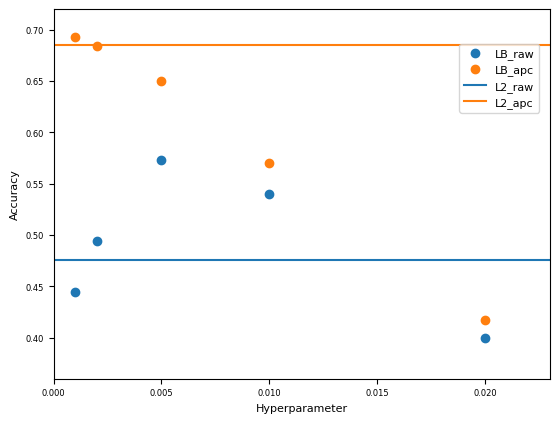

In [72]:
plt.figure(facecolor="white")
plt.scatter(performance_LB[:,2],performance_LB[:,0],label="LB_raw")
plt.scatter(performance_LB[:,2],performance_LB[:,1],label="LB_apc")
vmin = np.min(0)
vmax = np.max(0.023)
plt.plot([vmin,vmax],[AUC_ref.mean(0)[0],AUC_ref.mean(0)[0]],label="L2_raw")
plt.plot([vmin,vmax],[AUC_ref.mean(0)[1],AUC_ref.mean(0)[1]],label="L2_apc")
plt.xlabel("Hyperparameter")
plt.ylabel("Accuracy")
plt.ylim(0.36,0.72)
plt.xlim(0,0.023)
plt.legend(bbox_to_anchor=(0.04, 0.82, 0.95, .102))
plt.savefig("Fig2-2.pdf")

### Summary

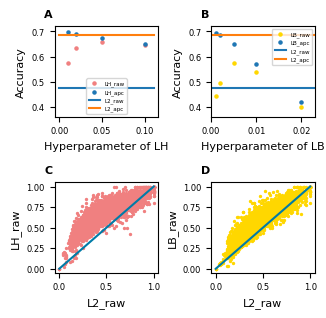

In [74]:
fig = plt.figure(figsize=(3.25,3.25),facecolor="white")
gs = fig.add_gridspec(2, 2)
axes = [fig.add_subplot(gs[i]) for i in range(4)]

plt.rcParams.update({'font.size': 8})
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)

fig.canvas.draw()

for n, ax in enumerate(axes):
  ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes,
            size=8, weight='bold')

vmin = np.min(0);vmax = np.max(0.023)


axes[0].scatter(performance_LH[:,2],performance_LH[:,0],s=5,label="LH_raw",c="lightcoral")
axes[0].scatter(performance_LH[:,2],performance_LH[:,1],s=5,label="LH_apc")
axes[0].plot([0,0.11],[AUC_ref.mean(0)[0],AUC_ref.mean(0)[0]],label="L2_raw")
axes[0].plot([0,0.11],[AUC_ref.mean(0)[1],AUC_ref.mean(0)[1]],label="L2_apc")
axes[0].set_xlabel("Hyperparameter of LH")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0.36,0.72)
axes[0].legend(prop={'size': 4})


axes[1].scatter(performance_LB[:,2],performance_LB[:,0],s=5,label="LB_raw",c="gold")
axes[1].scatter(performance_LB[:,2],performance_LB[:,1],s=5,label="LB_apc")
axes[1].plot([vmin,vmax],[AUC_ref.mean(0)[0],AUC_ref.mean(0)[0]],label="L2_raw")
axes[1].plot([vmin,vmax],[AUC_ref.mean(0)[1],AUC_ref.mean(0)[1]],label="L2_apc")
axes[1].set_xlabel("Hyperparameter of LB")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim(0.36,0.72)
axes[1].set_xlim(0,0.023)
axes[1].legend(prop={'size': 4})


LH_folder = f"LH/encoder_ref_0.05" # best LH_apc performance
ACC_LH = get_AUC(LH_folder,data=test_data,redo=False)


ACC_ref = get_AUC("ref_w_b",data=test_data,redo=False)

idx = ACC_LH.shape[0]
axes[2].plot( [0,1],[0,1], color="#007BA7")
axes[2].scatter(ACC_ref[:idx,0],ACC_LH[:,0],s=2,c="lightcoral")
axes[2].set_xlabel("L2_raw")
axes[2].set_ylabel(f"LH_raw")
#axes[2].tick_params(axis='both', which='major', labelsize=14)

LB_folder = f"LB/encoder_ref_0.005" # best LH_apc performance
ACC_LB = get_AUC(LB_folder,data=test_data,redo=False)

axes[3].plot( [0,1],[0,1], color="#007BA7")
axes[3].scatter(ACC_ref[:idx,0],ACC_LB[:,0],s=2,c="gold")
axes[3].set_xlabel("L2_raw")
axes[3].set_ylabel(f"LB_raw")
#axes[3].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig("unsupervised_learning.pdf")

## supervised learning

In [75]:
import joblib
from matplotlib import cm
from matplotlib import colors as c_rgb

In [77]:
!wget -q -nc http://www.structpred.club/~cybertruck/for_colab/precision/precision.pkl

In [78]:
precision = joblib.load('precision.pkl')
L2_apc = precision['L2_apc']
LB_apc = precision['LB_apc']
LH_apc = precision['LH_apc']
L2_raw = precision['L2_raw']
LB_raw = precision['LB_raw']
LH_raw = precision['LH_raw']
L2_NN = precision['L2_NN']
LB_NN = precision['LB_NN']
LH_NN = precision['LH_NN']

In [79]:
def set_box_color(bp, color):
    # plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

/tmp/ipykernel_2204408/735894749.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('GnBu', 256)


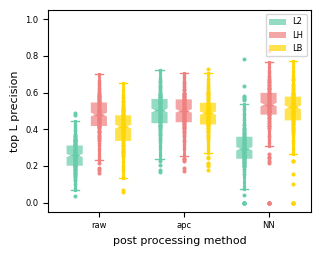

In [81]:

fig = plt.figure(figsize=(3.25,3.25*0.8),facecolor="white")

plt.rcParams.update({'font.size': 8})
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)

fig.canvas.draw()


top_index = 3

results = [[L2_raw[:, 0, top_index],L2_apc[:, 0, top_index], L2_NN[:, 0, top_index]],
           [LH_raw[:, 0, top_index], LH_apc[:, 0, top_index],  LH_NN[:, 0, top_index]],
           [LB_raw[:, 0, top_index],LB_apc[:, 0, top_index], LB_NN[:, 0, top_index]]
           ]

labels = ['L2', 'LH', "LB"]
tick_label = ['raw', 'apc', 'NN']

start_pos = np.array([-2.4,-0, 2.4, ])
tick_pos = np.array([0, 8.4, 16.8])

viridis = cm.get_cmap('GnBu', 256)
colors = viridis(np.linspace(0.4, 0.95, len(start_pos)))
colors = [c_rgb.to_rgb("mediumaquamarine"),c_rgb.to_rgb("lightcoral"),c_rgb.to_rgb("gold")]
opacity = 0.7
opacity_dot = 0.8

bpl_list = []
for ith, result in enumerate(results):
    positions = start_pos[ith] + tick_pos
    bpl = plt.boxplot(result,
                      positions=positions,
                      flierprops=dict(marker='o',
                              markerfacecolor=list(
                                  colors[ith][:3]) + [opacity_dot],
                              markersize=3, linestyle='none', markeredgecolor='white',
                              markeredgewidth=0),
                      notch=True,
                      patch_artist=True,
                      widths=1.6,
                      boxprops=dict(linestyle='-', linewidth=0.6,
                              facecolor=list(
                                  colors[ith][:3]) + [opacity],
                              edgecolor=list(colors[ith][:3]) + [0]),
                      whiskerprops=dict(linestyle='-', linewidth=2.0, color='black'))
    set_box_color(bpl,colors[ith])
    bpl_list.append(bpl["boxes"][0])

    # plot data points
    for jth, jresult in enumerate(result):
      plt.scatter([positions[jth]]*len(jresult), jresult, color=colors[ith],
              marker='o', s=2, alpha=opacity_dot)

plt.legend(bpl_list, ['L2', 'LH', 'LB',],
      loc='upper right',prop={'size':6})

plt.xticks(tick_pos, tick_label)
plt.ylim(-0.05, 1.05)
plt.xlim(-5, 21)
plt.ylabel("top L precision")
plt.xlabel("post processing method")
plt.tight_layout()
plt.savefig("NN.pdf")
plt.show()

# application


In [82]:
!wget -q -nc http://www.structpred.club/~cybertruck/LH/applications/asr.tar

In [83]:
!tar -zxf asr.tar


gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now


In [84]:
!wget -q -nc http://www.structpred.club/~cybertruck/science_evolution/ADKMLBay_3.fasta
!wget -q -nc http://www.structpred.club/~cybertruck/science_evolution/Adk_201602.fas
!wget -q -nc https://files.rcsb.org/download/1P3J.pdb
!wget -q -nc http://www.structpred.club/~cybertruck/science_evolution/ADK_paper.fasta

## GAGB
ref [Co-Evolutionary Fitness Landscapes for Sequence Design!](https://onlinelibrary.wiley.com/doi/abs/10.1002/anie.201713220)

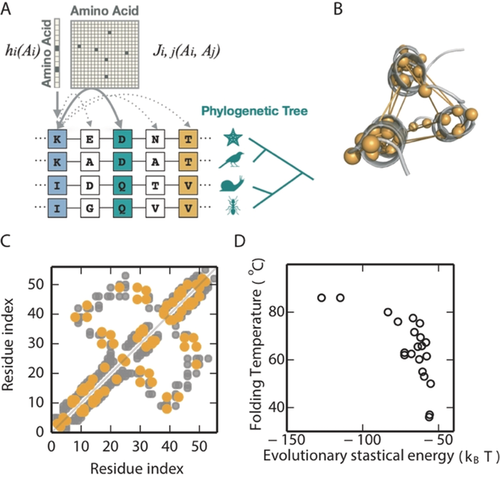

In [85]:
!wget -q -nc http://structpred.club/~cybertruck/LH/applications/gagb.tar

In [86]:
!tar -xvf gagb.tar

GAGB/
GAGB/GAGB_Tm_experiment.dat
GAGB/ga_msa.fas
GAGB/gb_msa.fas


In [87]:
#load msas
names,seqs_ga = parse_fasta("GAGB/ga_msa.fas")
seqs_gb = parse_aln("GAGB/gb_msa.fas")
msa_ga,_ = mk_msa(seqs_ga)
msa_gb,_ = mk_msa(seqs_gb)
print(msa_ga.shape,msa_gb.shape)

(940, 56) (702, 56)


In [88]:
# get folding temperature and test sequence
names,seqs = parse_fasta("GAGB/GAGB_Tm_experiment.dat")

tag = []
for i in names:
  tag.append([float(i.split()[1]),i[0]])
tag = np.array(tag)
tm = np.array(tag[:,0]).astype(float)
_,test_msa = mk_msa(seqs)

idx = np.where(tm>20) #unfold protein
tm = tm[idx]
test_msa = test_msa[idx]
tag = tag[idx]

p_type = np.array(tag[:,1])

A_type = np.where(p_type=="A")
B_type = np.where(p_type=="B")



In [89]:
# train the model
GA_V_L2,GA_W_L2 = GREMLIN(msa_ga,opt_iter=500,reg_mode="L2",param_flag=True)
GB_V_L2,GB_W_L2 = GREMLIN(msa_gb,opt_iter=500,reg_mode="L2",param_flag=True)

GA_V_LH,GA_W_LH  = GREMLIN(msa_ga,opt_iter=500,reg_mode="LH",param_flag=True)
GB_V_LH,GB_W_LH = GREMLIN(msa_gb,opt_iter=500,reg_mode="LH",param_flag=True)

In [90]:
return_H = True
test_GA_Loss_LH =  get_Hamiltonian_loss(test_msa,GA_W_LH,GA_V_LH,return_H = return_H)
test_GA_Loss_L2 =  get_Hamiltonian_loss(test_msa,GA_W_L2,GA_V_L2,return_H = return_H)

test_GB_Loss_LH =  get_Hamiltonian_loss(test_msa,GB_W_LH,GB_V_LH,return_H = return_H)
test_GB_Loss_L2 =  get_Hamiltonian_loss(test_msa,GB_W_L2,GB_V_L2,return_H = return_H)

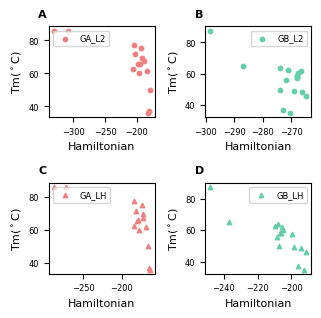

In [92]:
fig = plt.figure(figsize=(3.25,3.25),facecolor="white")
gs = fig.add_gridspec(2, 2)
axes = [fig.add_subplot(gs[i]) for i in range(4)]

plt.rcParams.update({'font.size': 8})
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)

fig.canvas.draw()

for n, ax in enumerate(axes):
  ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes,
            size=8, weight='bold')

axes[0].scatter(test_GA_Loss_L2[A_type],tm[A_type],label = "GA_L2",marker = "o",s=10,c='lightcoral')
axes[0].set_xlabel("Hamiltonian")
axes[0].set_ylabel("Tm($^\circ$C)")
axes[0].legend(prop={"size":6})

axes[1].scatter(test_GB_Loss_L2[B_type],tm[B_type],label = "GB_L2",marker = "o",s=10,c='mediumaquamarine')
axes[1].set_xlabel("Hamiltonian")
axes[1].set_ylabel("Tm($^\circ$C)")
axes[1].legend(prop={"size":6})

axes[2].scatter(test_GA_Loss_LH[A_type],tm[A_type],label = "GA_LH",marker = "^",s=10,c='lightcoral')
axes[2].set_xlabel("Hamiltonian")
axes[2].set_ylabel("Tm($^\circ$C)")
axes[2].legend(prop={"size":6})

axes[3].scatter(test_GB_Loss_LH[B_type],tm[B_type],label = "GB_LH",marker = "^",s=10,c='mediumaquamarine')
axes[3].legend(prop={"size":6})
axes[3].set_xlabel("Hamiltonian")
axes[3].set_ylabel("Tm($^\circ$C)")

plt.tight_layout()
plt.savefig("GAGB.pdf")


In [94]:
print("GA_L2",np.round(scipy.stats.spearmanr(test_GA_Loss_L2[A_type],tm[A_type])[0],2),"\n"
"GA_LH",np.round(scipy.stats.spearmanr(test_GA_Loss_LH[A_type],tm[A_type])[0],2),"\n"
"GB_L2",np.round(scipy.stats.spearmanr(test_GB_Loss_L2[B_type],tm[B_type])[0],2),"\n"
"GB_LH",np.round(scipy.stats.spearmanr(test_GB_Loss_LH[B_type],tm[B_type])[0],2)
)

GA_L2 -0.73 
GA_LH -0.78 
GB_L2 -0.37 
GB_LH -0.84


## chorismate mutase enyzme
 [An evolution-based model for designing chorismate mutase enzymes](https://science.sciencemag.org/content/369/6502/440/)

#### install bmDCA


In [95]:
# lib installation
! sudo apt-get update
! sudo apt-get install git gcc g++ automake autoconf pkg-config \
  libarmadillo-dev libopenblas-dev libarpack++2-dev

In [98]:
cd /content

In [6]:
%%bash
# download and install bmDCA
git clone https://github.com/ranganathanlab/bmDCA.git
cd bmDCA
./autogen.sh --prefix=/usr/local && \
make -j4 && \
make install
cd ..

In [100]:
!mkdir sampling_result

#### download dataset from paper


In [101]:
!wget -q -nc http://structpred.club/~cybertruck/LH/applications/bmdca.tar
!tar -xvf bmdca.tar

bmdca/
bmdca/aba3304_Table_S3.csv
bmdca/aba3304_Table_S2.csv
bmdca/science_head.fas
bmdca/aba3304_Table_S1.csv


#### parse the data

In [13]:
sample_dict = {}

with open("bmdca/aba3304_Table_S1.csv",'r') as f:
  seqs = []
  Es = []
  re = []
  for line in f.readlines()[4:]:
    line = line.strip().split(",")
    seq = str(line[-5])
    energy = float(line[-2])
    normre = float(line[-1])
    seqs.append(seq)
    Es.append(energy)
    re.append(normre)
sample_dict["nature"] = [seqs.copy(),Es.copy(),re.copy()]


with open("bmdca/aba3304_Table_S2.csv",'r') as f:
### three different sampling temperature
  flag = 0
  for line in f.readlines():
    line = line.strip()
    if "T=" in line:
      t = str(line.split("T=")[1].split(",")[0])
    if "Sequence" in line:
      flag = 1
      seqs = []
      Es = []
      re = []
      continue
    if flag == 1:
      if ",,,,,,," in line:
        flag = 0
        sample_dict[t] = [seqs.copy(),Es.copy(),re.copy()]
      else:
        line = line.split(",")
        seq = str(line[3])
        energy = float(line[6])
        normre = float(line[7])
        seqs.append(seq)
        Es.append(energy)
        re.append(normre)
  sample_dict[t] = [seqs.copy(),Es.copy(),re.copy()]

flag = 0
with open("bmdca/aba3304_Table_S3.csv",'r') as f:
  seqs = []
  Es = []
  re = []
  for line in f.readlines()[4:]:
    line = line.strip().split(",")
    seq = str(line[1])
    energy = float(line[4])
    normre = float(line[5])
    seqs.append(seq)
    Es.append(energy)
    re.append(normre)

#idx = 0,1,2
sample_dict["pssm"] = [seqs.copy(),Es.copy(),re.copy()]


### run LH model


### load ref L2

In [14]:
# a label based function
def get_loss(t,W,V):
  seqs = sample_dict[t][0]
  _,msa = mk_msa(seqs)
  return get_Hamiltonian_loss(msa,W,V)

the contact map generated by LH


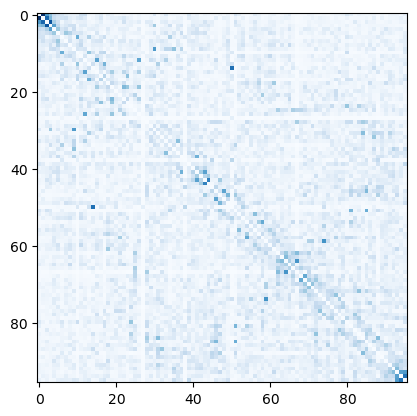

In [17]:
t = "nature"
seqs = sample_dict[t][0]
Es = sample_dict[t][1]
re = sample_dict[t][2]
msa_ori_nature,msa_nature = mk_msa(seqs)

V_LH,W_LH = GREMLIN(msa_ori_nature,reg_mode="LH",lambda_LH=0.1,param_flag=True)

Loss_mean = np.mean(get_loss("nature",W_LH,V_LH))
for t in ["nature","0.33","0.66","1","pssm"]:
  Loss_LH = get_loss(t,W_LH,V_LH)
  Loss_LH = Loss_LH - Loss_mean
  #idx = 3
  sample_dict[t].append(Loss_LH)

raw, apc = get_mtx(W_LH)
print("the contact map generated by LH")
plt.imshow(raw,cmap="Blues")
plt.grid(False)

#### classify sequences by functions

Both of these two failed to separate because of natural sequence pollution!

463 666
309 184
193 317
31 584


/data/ruima/mambaforge/envs/afdesign/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/data/ruima/mambaforge/envs/afdesign/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


0 325


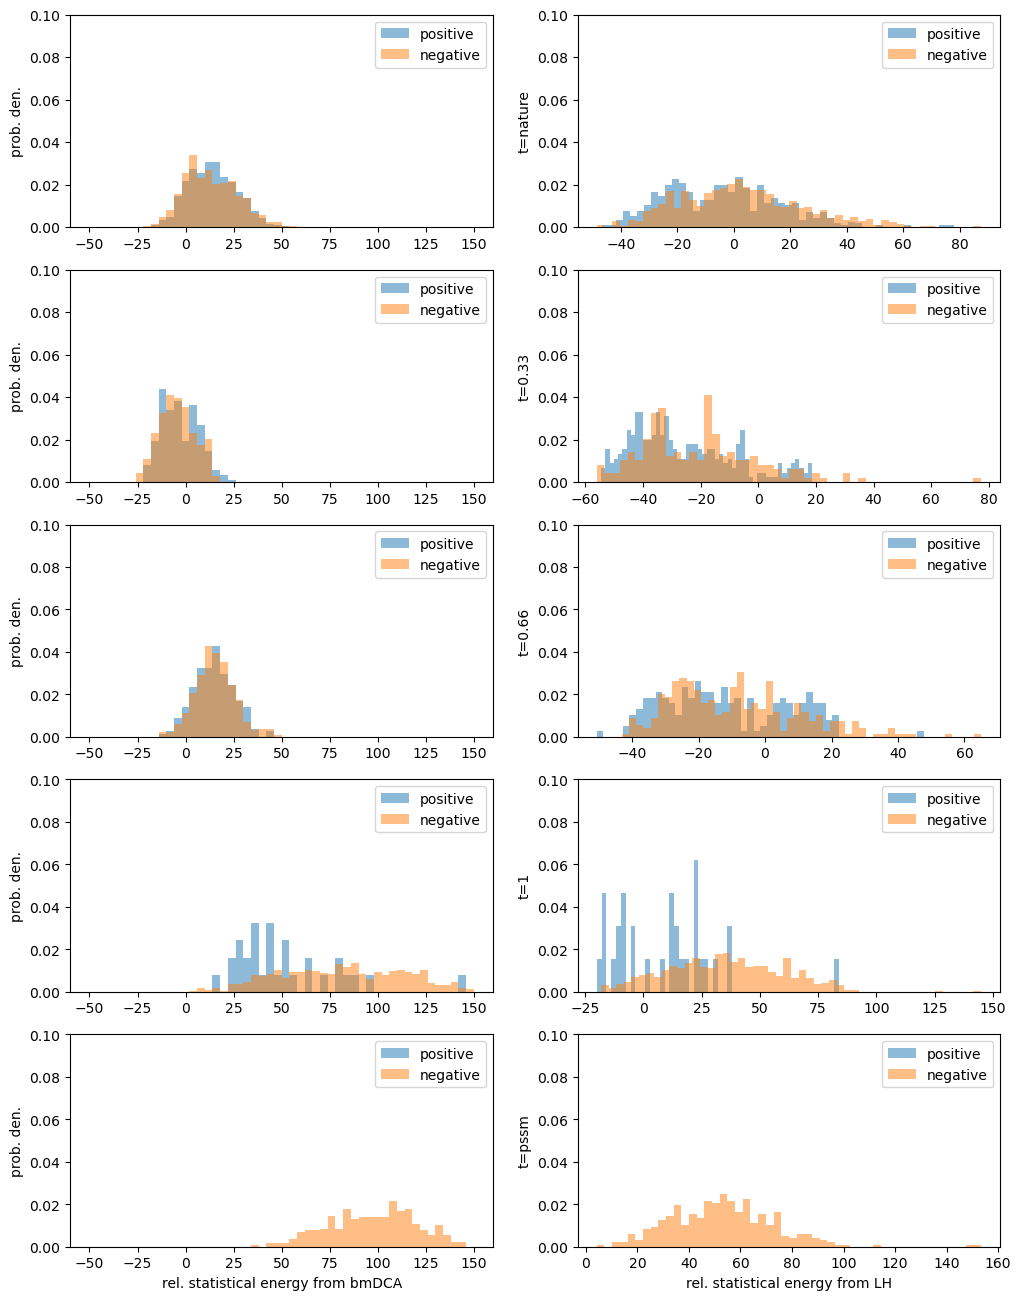

In [18]:
plt.figure(figsize=(12,16),facecolor="white")
cutoff=0.25
for i,t in enumerate(["nature","0.33","0.66","1","pssm"]):

  re = sample_dict[t][2]

  Positive_idx = np.where(np.array(re)>cutoff)
  Negative_idx = np.where(np.array(re)<=cutoff)

  plt.subplot(5,2,2*i+1)
  Es = np.array(sample_dict[t][1])
  plt.hist(Es[Positive_idx], bins=50,alpha=0.5,density=True,range=(-50,150),label="positive")
  plt.hist(Es[Negative_idx], bins=50,alpha=0.5,density=True,range=(-50,150),label="negative")
  plt.ylim(0,0.1)
  plt.ylabel("prob. den.")
  plt.legend()
  if i ==4: #the nineth plot
    plt.xlabel("rel. statistical energy from bmDCA")

  plt.subplot(5,2,2*i+2)
  plt.ylabel(f"t={t}")
  Es = sample_dict[t][3]
  plt.hist(Es[Positive_idx], bins=50,alpha=0.5,density=True,label="positive")
  plt.hist(Es[Negative_idx], bins=50,alpha=0.5,density=True,label="negative")
  print(len(Es[Positive_idx]),len(Es[Negative_idx]))
  #plt.ylabel("prob. den.")
  plt.ylim(0,0.1)
  plt.legend()
  if i ==4: #the nineth plot
    plt.xlabel("rel. statistical energy from LH")

plt.legend()
plt.show()

In [19]:
# reverse tranlate numbers into AAs for furthur use
t = "nature"
msa_ori,msa = mk_msa(sample_dict[t][0])
re = sample_dict[t][2]
Positive_idx = np.where(np.array(re)>cutoff)
msa_ori_filter = msa_ori[Positive_idx]
seqs = []
for i in range(msa_ori_filter.shape[0]):
  seq = []
  for j in msa_ori_filter[i]:
    aa = alphabet[j]
    seq.append(aa)
  seq = "".join(seq)
  seqs.append(seq)

#changing aln file to fas file
with open("CM_0.25.fas", 'w') as out:
  for i in range(len(seqs)):
    out.write(f">seqs_{i}\n{seqs[i]}\n")

### Rerun bmDCA with filtered MSA

In [20]:
### MSA filter with all norm r.e. >0.25
##suspect there exists unfunctional sequences in the same MSA.
sample_filter_dict = sample_dict.copy()
seqs = sample_filter_dict["nature"][0]

#get the Es >0.25 as input data
pos_idx = np.where(np.array(sample_filter_dict["nature"][2]) >0.25)
seq_filter = np.array(seqs)[pos_idx]

#changing aln file to fas file
with open("msa.fas", 'w') as out:
  for i in range(len(seq_filter)):
    out.write(f">seqs_{i}\n{seq_filter[i]}\n")

In [114]:
# this step took too long time (over 100h in 12 core CPUs) to run, so I uploaded the result at somewhere
# if you want to repeat the bmDCA, you can uncomment the commands and try running this locally.
'''%%bash
bmdca -i msa.fas -r -d bmdca_result -c bmDCA/example/bmdca.conf
arma2ascii -p bmdca_result/parameters_h_final.bin -P bmdca_result/parameters_J_final.bin'''

!wget -q -nc  http://structpred.club/~cybertruck/LH/applications/parameters_1900.txt -O parameter_L2BM.txt

In [29]:
def txt2mtx(filename):
  W = np.zeros_like(W_LH)
  V = np.zeros_like(V_LH)
  with open(filename, 'r') as filehandle:
    for line in filehandle:
      line = line.strip()
      line = line.split(" ")
      if line[0] == "J":
        i = int(line[1])
        j = int(line[2])
        a = int(line[3])
        b = int(line[4])
        n = float(line[5])
        W[i,a,j,b] = n
        W[j,a,i,b] = n
      if line[0] == "h":
        i = int(line[1])
        j = int(line[2])
        n = float(line[3])
        V[i,j] = n
  return V,W

V_L2BM,W_L2BM = txt2mtx("parameter_L2BM.txt")

### calculating W matrix

In [30]:
### MSA filter with all norm r.e. >0.25
##suspect there exists unfunctional sequences in the same MSA.

seqs = sample_dict["nature"][0]
pos_idx = np.where(np.array(re) >0.25)
seq_filter = np.array(seqs)[pos_idx]

#changing aln file to fas file
with open("msa.fas", 'w') as out:
  for i in range(len(seq_filter)):
    out.write(f">seqs_{i}\n{seq_filter[i]}\n")

# calculate L2 and LH
V_LH, W_LH = GREMLIN(msa_ori_nature[pos_idx],reg_mode="LH",param_flag=True)
V_L2, W_L2 = GREMLIN(msa_ori_nature[pos_idx],reg_mode="L2",param_flag=True)

#V_LH, W_LH = GREMLIN(msa_ori_nature,reg_mode="LH",param_flag=True)
#V_L2, W_L2 = GREMLIN(msa_ori_nature,reg_mode="L2",param_flag=True)

LH_mean = np.mean(get_loss("nature",W_LH,V_LH))
L2_mean = np.mean(get_loss("nature",W_L2,V_L2))
L2BM_mean = np.mean(get_loss("nature",W_L2BM,V_L2BM))

for t in ["nature","0.33","0.66","1","pssm"]:
  #idx = 4
  Loss_LH = get_loss(t,W_LH,V_LH)
  Loss_LH = Loss_LH - LH_mean
  sample_dict[t].append(Loss_LH)
  #idx = 5
  Loss_L2 = get_loss(t,W_L2,V_L2)
  Loss_L2 = Loss_L2 - L2_mean
  sample_dict[t].append(Loss_L2)
  #idx = 6
  Loss_L2BM = get_loss(t,W_L2BM,V_L2BM)
  Loss_L2BM = Loss_L2BM - L2BM_mean
  sample_dict[t].append(Loss_L2BM)

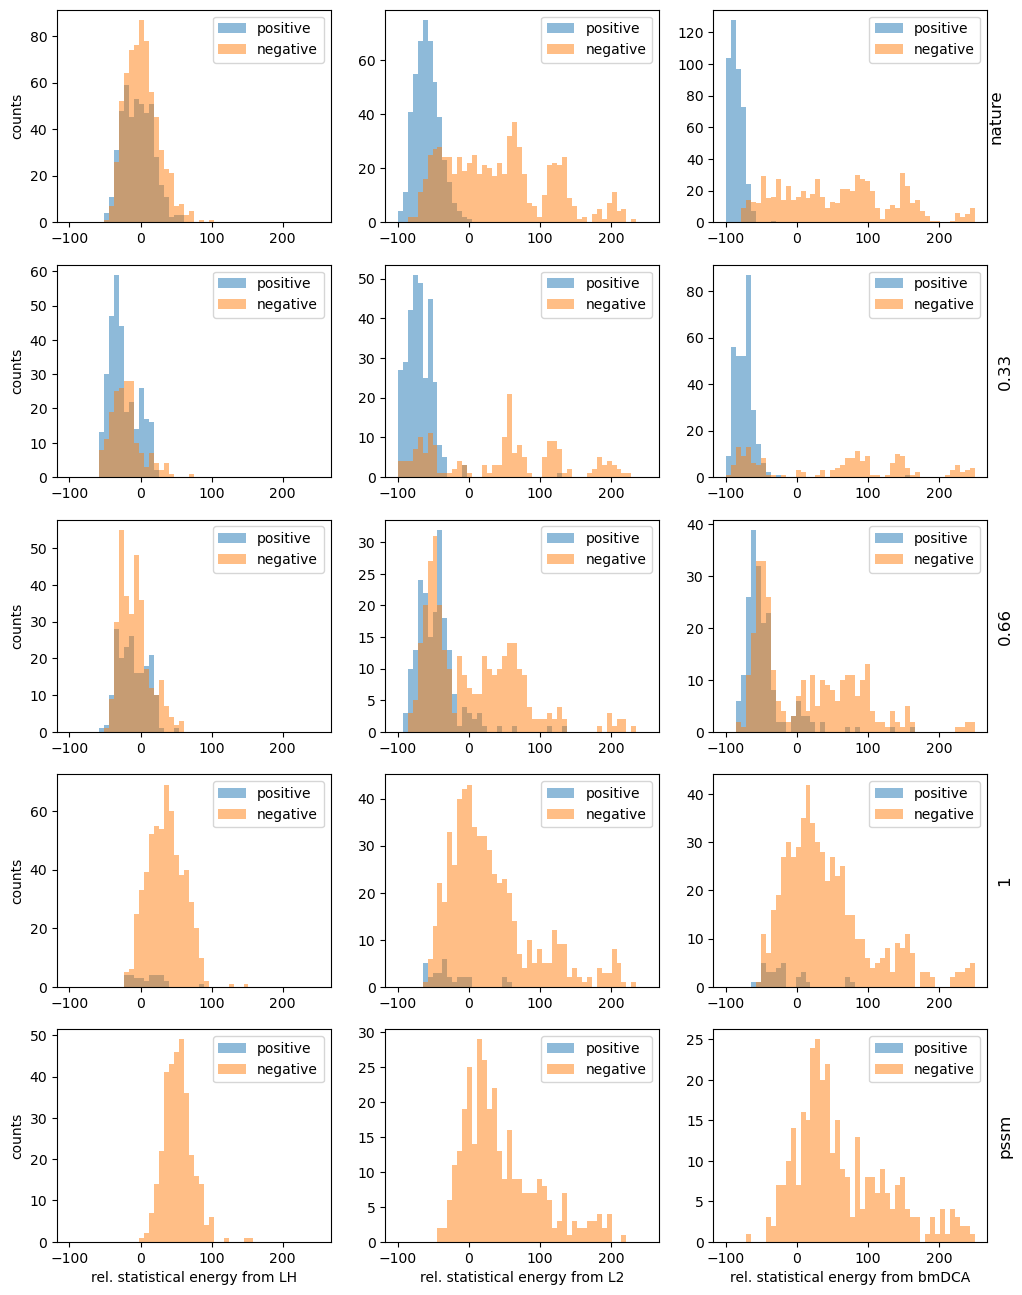

In [55]:
plt.figure(figsize=(12,16),facecolor="white")
cutoff=0.25
for i,t in enumerate(["nature","0.33","0.66","1","pssm"]):

  re = sample_dict[t][2]

  Positive_idx = np.where(np.array(re)>cutoff)
  Negative_idx = np.where(np.array(re)<=cutoff)


  plt.subplot(5,3,3*i+1)
  Es = sample_dict[t][4] # MSA filter with LH
  plt.hist(Es[Positive_idx], bins=50,alpha=0.5,range=(-100,250),label="positive")
  plt.hist(Es[Negative_idx], bins=50,alpha=0.5,range=(-100,250),label="negative")
  #plt.ylabel("prob. den.")
  #plt.ylim(0,0.1)
  plt.legend()
  plt.ylabel("counts")
  if i ==4: #the nineth plot
    plt.xlabel("rel. statistical energy from LH")


  plt.subplot(5,3,3*i+2)
  Es = sample_dict[t][5] # MSA filter with L2
  plt.hist(Es[Positive_idx], bins=50,alpha=0.5,range=(-100,250),label="positive")
  plt.hist(Es[Negative_idx], bins=50,alpha=0.5,range=(-100,250),label="negative")
  #plt.ylabel("prob. den.")
  #plt.ylim(0,0.1)
  plt.legend()
  if i ==4: #the nineth plot
    plt.xlabel("rel. statistical energy from L2")


  plt.subplot(5,3,3*i+3)
  Es = sample_dict[t][6] # MSA filter with bmDCA
  plt.hist(Es[Positive_idx], bins=50,alpha=0.5,range=(-100,250),label="positive")
  plt.hist(Es[Negative_idx], bins=50,alpha=0.5,range=(-100,250),label="negative")
  #plt.ylabel("prob. den.")
  #plt.ylim(0,0.1)
  plt.legend()
  plt.ylabel(t, labelpad=-235,fontsize=12)
  if i ==4: #the nineth plot
    plt.xlabel("rel. statistical energy from bmDCA")

plt.legend()
plt.savefig("filtered_msa_bmdca.pdf")

#### resample


In [56]:
# utils
def save_parameter(filename,W,V):
  ''' this function is to translate potts model paramter
  to a bmdca_sample input format.
  W: two body term
  V: one body term
  '''
  L,A = V.shape
  with open(filename, 'w') as out:
    for i in range(L):
      for j in range(L):
        for a in range(A):
          for b in range(A):
            if i<j:
              out.write(f"J {i} {j} {a} {b} {W[i,a,j,b]}\n")
    for i in range(L):
      for a in range(A):
        out.write(f"H {i} {a} {V[i,a]}\n")

save_parameter("parameter_L2.txt",W_L2,V_L2)
save_parameter("parameter_LH.txt",W_LH,V_LH)

### sequence sampling


In [7]:
!./bmDCA/src/bmdca_sample -h

bmdca_sample usage:
(e.g. bmdca_sample -p <params h> -P <params|params J> -c <config file> \
                   -n <# samples per thread> -r <# threads> \
                   -d <directory> -o <output flle>)
  -p: parameters (txt) _or_ fields h (bin)
  -P: couplings J (bin), required if fields h given
  -d: destination directory
  -o: output file name
  -r: # independent sampling runs
  -n: # samples obtained per sampling run
  -c: config file
  -h: print usage (i.e. this message)


In [8]:
# 10 independent runs * 1,000 sequneces = 10,000 sequences
!./bmDCA/src/bmdca_sample -p parameter_L2.txt -d sampling_result/ -o L2.txt -n 10000
!./bmDCA/src/bmdca_sample -p parameter_LH.txt -d sampling_result/ -o LH.txt -n 10000
!./bmDCA/src/bmdca_sample -p parameter_L2BM.txt -d sampling_result/ -o L2BM.txt -n 10000

initializing sampler... 0.308829 sec

sampling model with mcmc... 8.50704 sec
updating mcmc stats with samples... 0.437372 sec
computing sequence energies and correlations... 2.60651 sec
writing final sequences... done
initializing sampler... 0.314262 sec

sampling model with mcmc... 9.02593 sec
updating mcmc stats with samples... 0.462341 sec
computing sequence energies and correlations... 2.30614 sec
decreasing burn-in time to 60000
writing final sequences... done
initializing sampler... 0.326287 sec

sampling model with mcmc... 8.45167 sec
updating mcmc stats with samples... 0.4228 sec
computing sequence energies and correlations... 3.09431 sec
increasing wait time to 1500
increasing burn-in time to 150000
resampling...
writing temporary files
sampling model with mcmc... 12.6476 sec
updating mcmc stats with samples... 0.408273 sec
computing sequence energies and correlations... 2.8378 sec
writing final sequences... done


### calculate pair_pssm


In [21]:
#get one hotted msa
names, seqs_L2 = parse_fasta("./sampling_result/L2.txt")
_, msa_gen_L2 = mk_msa(seqs_L2) 

names, seqs_LH = parse_fasta("./sampling_result/LH.txt")
_, msa_gen_LH = mk_msa(seqs_LH)

names, seqs_L2BM = parse_fasta("./sampling_result/L2BM.txt")
_, msa_gen_L2BM = mk_msa(seqs_L2BM)

#_,msa_nature = mk_msa(seq_filter)

### pairwise_frequency


In [22]:
# the input pair_pssm information
train_pssm = get_pssm(msa_nature)
train_pair_pssm = get_pair_pssm(msa_nature)

In [24]:
L2_pssm = get_pssm(msa_gen_L2)
LH_pssm = get_pssm(msa_gen_LH)
L2BM_pssm = get_pssm(msa_gen_L2BM)

L2_pair_pssm = get_pair_pssm(msa_gen_L2)
LH_pair_pssm = get_pair_pssm(msa_gen_LH)
L2BM_pair_pssm = get_pair_pssm(msa_gen_L2BM)

# Null_pair_pssm = get_pair_pssm(msa_null)

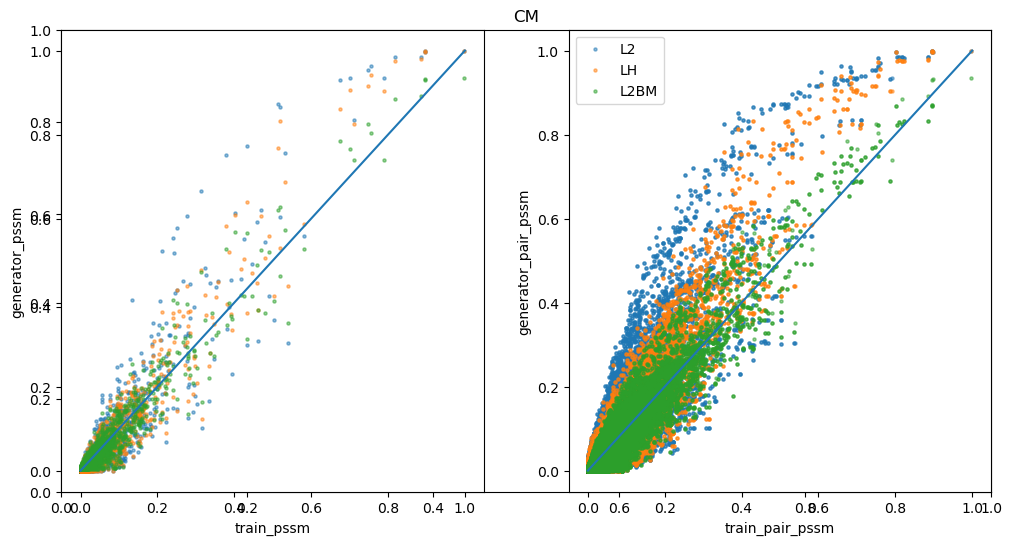

In [43]:
plt.figure(figsize=(12,6),facecolor="white")

plt.title("CM")
plt.subplot(1,2,1)
plt.scatter(train_pssm,L2_pssm,s=5,alpha=0.5,label="L2")
plt.scatter(train_pssm,LH_pssm,s=5,alpha=0.5,label="LH")
plt.scatter(train_pssm,L2BM_pssm,s=5,alpha=0.5,label="L2BM")
plt.plot([0,1],[0,1])
plt.xlabel("train_pssm")
plt.ylabel("generator_pssm")

plt.subplot(1,2,2)
plt.scatter(train_pair_pssm,L2_pair_pssm,s=5,alpha=0.5,label="L2")
plt.scatter(train_pair_pssm,LH_pair_pssm,s=5,alpha=0.5,label="LH")
plt.scatter(train_pair_pssm,L2BM_pair_pssm,s=5,alpha=0.5,label="L2BM")

plt.plot([0,1],[0,1])
plt.xlabel("train_pair_pssm")
plt.ylabel("generator_pair_pssm")

plt.legend()
plt.savefig("pair_pssm.png")

#### coevolutionary info check using MI


In [44]:
def get_MI(pssm,pair_pssm):
  H = np.sum(-pssm * np.log(pssm+1e-8),-1)
  HH = np.sum(-pair_pssm * np.log(pair_pssm+1e-8),(1,3))
  MI =  H[None,:] + H[:,None] - HH
  np.fill_diagonal(MI,0)
  ap = np.sum(MI,0)
  apc  = MI - ap[None,:]*ap[:,None]/np.sum(ap)

  return MI,apc

In [45]:
MI_train,MI_train_APC = get_MI(train_pssm,train_pair_pssm)
MI_L2,MI_L2_APC = get_MI(L2_pssm,L2_pair_pssm)
MI_LH,MI_LH_APC = get_MI(LH_pssm,LH_pair_pssm)
MI_L2BM,MI_L2BM_APC = get_MI(L2BM_pssm,L2BM_pair_pssm)
#MI_pssm,MI_pssm_APC = get_MI(train_pssm,Null_pair_pssm)

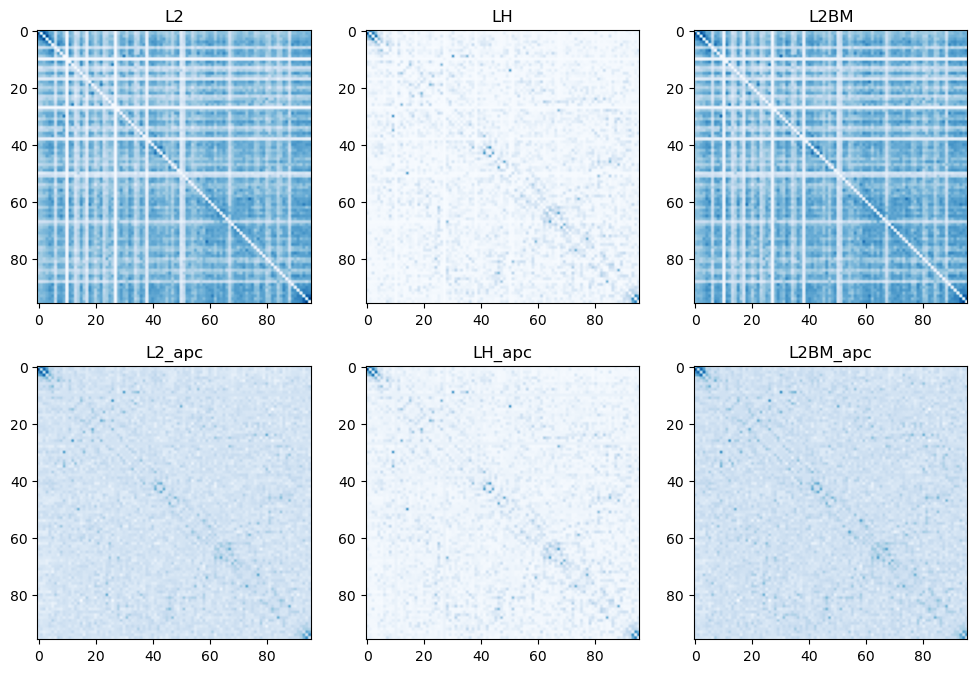

In [57]:
raw_L2,apc_L2 = get_mtx(W_L2)
raw_LH,apc_LH = get_mtx(W_LH)
raw_L2BM,apc_L2BM = get_mtx(W_L2BM)
plt.figure(figsize=(12,8),facecolor="white")
plt.subplot(2,3,1); plt.imshow(raw_L2,cmap="Blues");plt.title("L2")
plt.subplot(2,3,4); plt.imshow(apc_L2,cmap="Blues");plt.title("L2_apc")
plt.subplot(2,3,2); plt.imshow(raw_LH,cmap="Blues");plt.title("LH")
plt.subplot(2,3,5); plt.imshow(apc_LH,cmap="Blues");plt.title("LH_apc")
plt.subplot(2,3,3); plt.imshow(raw_L2BM,cmap="Blues");plt.title("L2BM")
plt.subplot(2,3,6); plt.imshow(apc_L2BM,cmap="Blues");plt.title("L2BM_apc")

plt.savefig("resample_MI.pdf")

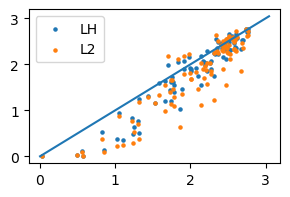

In [58]:
plt.figure(figsize=(3.25,2))
train_entropy = np.sum(-train_pssm * np.log(train_pssm +1e-8),1)
LH_entropy = np.sum(-LH_pssm * np.log(LH_pssm +1e-8),1)
L2BM_entropy = np.sum(-L2BM_pssm * np.log(L2BM_pssm +1e-8),1)
L2_entropy = np.sum(-L2_pssm * np.log(L2_pssm +1e-8),1)
plt.scatter(train_entropy,LH_entropy,label="LH",s=5)
plt.scatter(train_entropy,L2_entropy,label="L2",s=5)
#plt.scatter(train_entropy,L2BM_entropy,label="L2BM",s=5)

plt.plot([0,np.log(21)],[0,np.log(21)])
plt.legend()

In [59]:
print(np.corrcoef(train_entropy,LH_entropy)[0,1],np.corrcoef(train_entropy,L2_entropy)[0,1])


0.9572502816155314 0.9158343987453132


### clustering


In [26]:
from sklearn.decomposition import PCA

In [31]:
return_H = True
Generate_Hamiltonian_L2 = get_Hamiltonian_loss(msa_gen_L2,W_L2,V_L2,return_H=return_H)
Generate_Hamiltonian_LH = get_Hamiltonian_loss(msa_gen_LH,W_LH,V_LH,return_H=return_H)
Generate_Hamiltonian_L2BM = get_Hamiltonian_loss(msa_gen_L2BM,W_L2BM,V_L2BM,return_H=return_H)

In [32]:
 _,msa_L2BM_paper = mk_msa(sample_dict["0.33"][0])

In [33]:
msa_flat = msa_nature.reshape(msa_nature.shape[0],-1)


In [34]:
PCA_model = PCA(50).fit(msa_flat)

In [35]:
msa_L2_flat = msa_gen_L2.reshape(msa_gen_L2.shape[0],-1)
msa_LH_flat = msa_gen_LH.reshape(msa_gen_LH.shape[0],-1)
msa_L2BM_flat = msa_gen_L2BM.reshape(msa_gen_L2BM.shape[0],-1)
msa_L2BM_paper_flat = msa_L2BM_paper.reshape(msa_L2BM_paper.shape[0],-1)

In [36]:
nature_lr = PCA_model.transform(msa_flat)
L2_lr = PCA_model.transform(msa_L2_flat)
LH_lr = PCA_model.transform(msa_LH_flat)
L2BM_lr = PCA_model.transform(msa_L2BM_flat)
L2BM_paper_lr = PCA_model.transform(msa_L2BM_paper_flat)

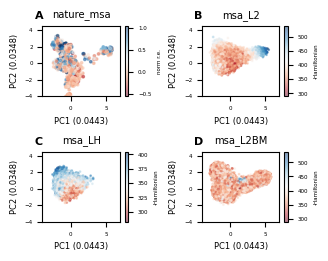

In [38]:
x_range = [-4,7]
y_range = [-4,4.5]

fig = plt.figure(figsize=(3.25,3.25*0.8),facecolor="white")
gs = fig.add_gridspec(2, 2)
axes = [fig.add_subplot(gs[i]) for i in range(4)]

plt.rcParams.update({'font.size': 6})
plt.rc('xtick', labelsize=4)
plt.rc('ytick', labelsize=4)

fig.canvas.draw()

for n, ax in enumerate(axes):
  ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes,
            size=8, weight='bold')


axes[0].set_title("nature_msa")
sc = axes[0].scatter(nature_lr[:,0],nature_lr[:,1],c=sample_dict["nature"][2],s=3,alpha=0.5,cmap="RdBu",rasterized=True)
axes[0].set_xlabel(f"PC1 ({PCA_model.explained_variance_ratio_[0]:.3})",size=6)
axes[0].set_ylabel(f"PC2 ({PCA_model.explained_variance_ratio_[1]:.3})",size=6)
axes[0].set_xlim(x_range)
axes[0].set_ylim(y_range)

cb = fig.colorbar(sc, ax=axes[0])
cb.set_label(label=f"norm r.e.",size=4)

axes[1].set_title("msa_L2")
sc =  axes[1].scatter(L2_lr[:,0],L2_lr[:,1],c=-Generate_Hamiltonian_L2,s=1,alpha=0.5,cmap="RdBu",rasterized=True)

axes[1].set_xlabel(f"PC1 ({PCA_model.explained_variance_ratio_[0]:.3})",size=6)
axes[1].set_ylabel(f"PC2 ({PCA_model.explained_variance_ratio_[1]:.3})",size=6)
axes[1].set_xlim(x_range)
axes[1].set_ylim(y_range)

cb = fig.colorbar(sc, ax=axes[1])
cb.set_label(label=f"-Hamiltonian",size=4)

axes[2].set_title("msa_LH")
sc = axes[2].scatter(LH_lr[:,0],LH_lr[:,1],c=-Generate_Hamiltonian_LH,s=1,alpha=0.5,cmap="RdBu",rasterized=True)
axes[2].set_xlabel(f"PC1 ({PCA_model.explained_variance_ratio_[0]:.3})",size=6)
axes[2].set_ylabel(f"PC2 ({PCA_model.explained_variance_ratio_[1]:.3})",size=6)
axes[2].set_xlim(x_range)
axes[2].set_ylim(y_range)
cb = fig.colorbar(sc, ax=axes[2])
cb.set_label(label=f"-Hamiltonian",size=4)

axes[3].set_title("msa_L2BM")
sc = axes[3].scatter(L2BM_lr[:,0],L2BM_lr[:,1],c=-Generate_Hamiltonian_L2,s=1,alpha=0.5,cmap="RdBu",rasterized=True)
axes[3].set_xlabel(f"PC1 ({PCA_model.explained_variance_ratio_[0]:.3})",size=6)
axes[3].set_ylabel(f"PC2 ({PCA_model.explained_variance_ratio_[1]:.3})",size=6)
axes[3].set_xlim(x_range)
axes[3].set_ylim(y_range)
cb = fig.colorbar(sc, ax=axes[3])
cb.set_label(label=f"-Hamiltonian",size=4)

plt.tight_layout()
plt.savefig("sequence_PCA.pdf")


### Interpretability

In [39]:
# !wget -q -nc http://www.structpred.club/~cybertruck/science_evolution/ASC.fas
!wget -q -nc http://www.structpred.club/~cybertruck/LH/applications/ASR/ADKMLBay_3.fasta
!wget -q -nc http://www.structpred.club/~cybertruck/LH/applications/ASR/Adk_201602.fas
!wget -q -nc https://files.rcsb.org/download/1P3J.pdb
!wget -q -nc http://www.structpred.club/~cybertruck/LH/applications/ASR/ADK_paper.fasta

#### parse data

In [40]:
# get MSA
_,seqs = parse_fasta('Adk_201602.fas')
# seqs = parse_aln('subtilis.aln')
seqs = seqs[:-1]
msa_ori,msa = mk_msa(seqs[1:])
seq = seqs[0]
L = len(seq)
print(msa.shape)

# get sequences
heads,prots_ASR = parse_fasta('ADKMLBay_3.fasta')
prots_ASR = prots_ASR[:-2]
heads = heads[:-2]
infos = [head.split() for head in heads]

# get temperature
temperature = []
for ith, prot in enumerate(prots_ASR):
  temperature.append(float(infos[ith][1]))

# get activity
activity = []
for ith, prot in enumerate(prots_ASR):
  activity.append(float(infos[ith][2]))

# delete some proteins
idx = []
opening = []
for ith, prot in enumerate(prots_ASR):
  if infos[ith][3] == 'NA':
    idx.append(ith)
  else:
    opening.append(float(infos[ith][3]))

sel = set(range(len(prots_ASR)))
sel = list(sel - set(idx))
prots_ASR = [prots_ASR[isel] for isel in sel]
infos = [infos[isel] for isel in sel]
temperature = [temperature[isel] for isel in sel]
activity = [activity[isel] for isel in sel]

(9943, 217, 21)


In [41]:
_,paper_seqs = parse_fasta('ADK_paper.fasta')
# seqs = parse_aln('subtilis.aln')
new_paper_seqs = []
for seq in paper_seqs:
  new_paper_seqs.append(seq[2:157] + '-' + seq[159:] + '-'*5)
msa_ori_paper,msa_paper = mk_msa(new_paper_seqs)

In [42]:
_,prots_msa = mk_msa(prots_ASR)

In [43]:
# train the model
V_L2,W_L2 = GREMLIN(msa_ori,opt_iter=500,reg_mode="L2",param_flag=True)
V_LH,W_LH = GREMLIN(msa_ori,opt_iter=500,reg_mode="LH",lambda_LH=0.5,param_flag=True)
V_LB,W_LB = GREMLIN(msa_ori,opt_iter=500,reg_mode="LB",param_flag=True)

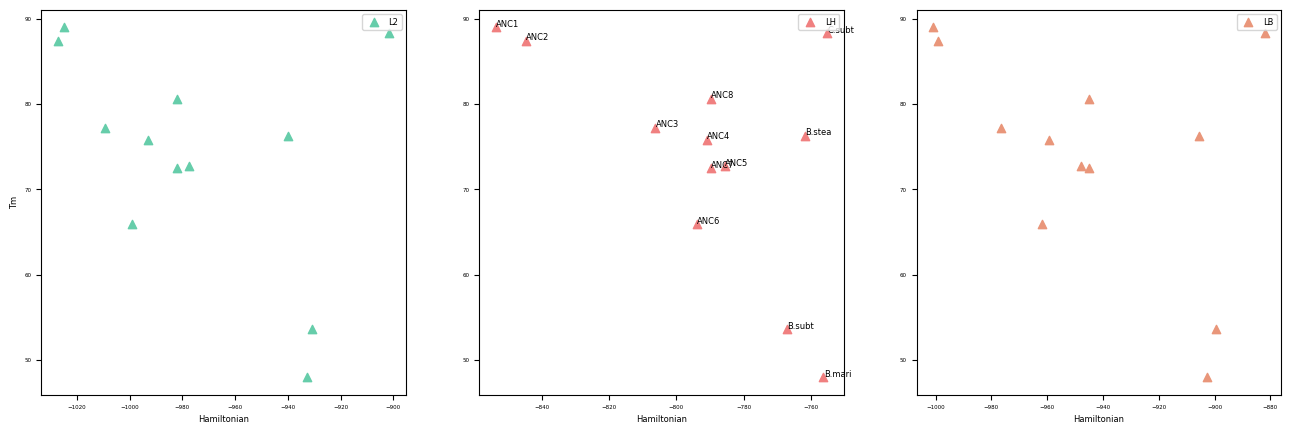

In [44]:

prot_H_LH = get_Hamiltonian_loss(prots_msa,W_LH,V_LH,return_H=True)

prot_H_L2 = get_Hamiltonian_loss(prots_msa,W_L2,V_L2,return_H=True)

prot_H_LB = get_Hamiltonian_loss(prots_msa,W_LB,V_LB,return_H=True)

plt.figure(figsize=[16,5],facecolor="white")

plt.subplot(131)
plt.scatter(prot_H_L2, temperature, marker = "^", c='mediumaquamarine', label='L2')
#for i in range(len(infos)):
 # plt.annotate(infos[i][0][:6], xy=(prot_H_L2[i], temperature[i]), xytext=(prot_H_L2[i]+0.1, temperature[i]+0.1))
plt.xlabel("Hamiltonian");plt.ylabel("Tm");plt.legend()


plt.subplot(132)
plt.scatter(prot_H_LH, temperature, marker = "^", c='lightcoral', label='LH')
for i in range(len(infos)):
  plt.annotate(infos[i][0][:6], xy=(prot_H_LH[i], temperature[i]), xytext=(prot_H_LH[i]+0.1, temperature[i]+0.1))
plt.xlabel("Hamiltonian");#plt.ylabel("Tm");
plt.legend()

plt.subplot(133)
plt.scatter(prot_H_LB, temperature, marker = "^", c='darksalmon', label='LB')
#for i in range(len(infos)):
 # plt.annotate(infos[i][0][:6], xy=(prot_H_LN[i], temperature[i]), xytext=(prot_H_LN[i]+0.1, temperature[i]+0.1))
plt.xlabel("Hamiltonian");#plt.ylabel("Tm");
plt.legend()
plt.savefig("ADK_Tm.pdf")

In [45]:
def get_sin_contact(prot, W,V=None):
  a2n = {a:n for n,a in enumerate(alphabet)}
  prot_oh = np.array([a2n.get(aa, len(alphabet)-1) for aa in prot])
  prot_oh = np.eye(21)[prot_oh]
  prot_mask = np.einsum("ij,kl->ijkl",prot_oh,prot_oh)
  return np.sum(prot_mask*W,(1,3))

In [46]:
# B.subtilis
contact_B = get_sin_contact(prots_ASR[0], W_LH)
# ANC1
contact_1 = get_sin_contact(prots_ASR[9], W_LH)

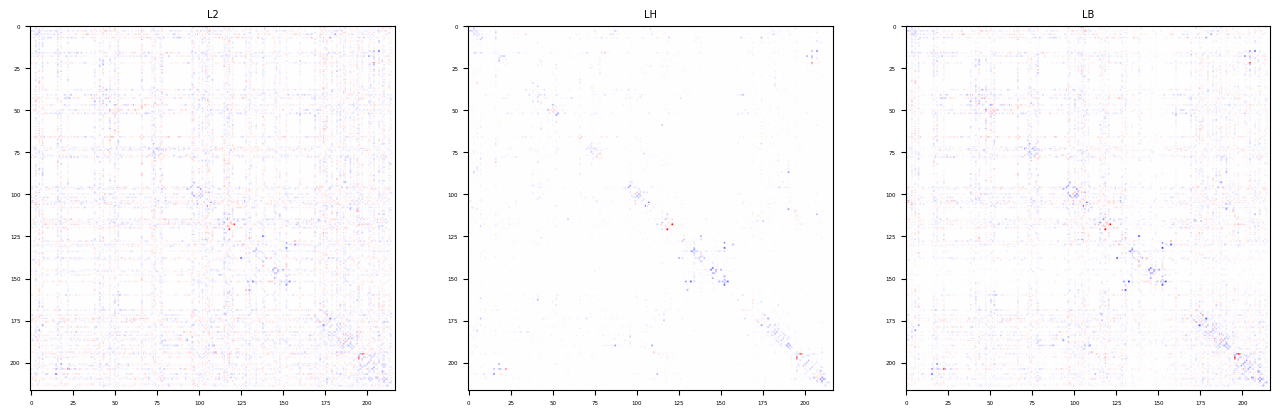

In [48]:
plt.figure(figsize=[16,5],facecolor="white")

plt.subplot(131)
plt.title("L2")
contact_Bs = get_sin_contact(prots_ASR[0], W_L2)
contact_AN1 = get_sin_contact(prots_ASR[9], W_L2)
plt.imshow(contact_Bs - contact_AN1, cmap="bwr",vmin=-0.8,vmax=0.8)

plt.subplot(132)
plt.title("LH")
contact_Bs = get_sin_contact(prots_ASR[0], W_LH)
contact_AN1 = get_sin_contact(prots_ASR[9], W_LH)
plt.imshow(contact_Bs - contact_AN1, cmap="bwr",vmin=-0.8,vmax=0.8)

plt.subplot(133)
plt.title("LB")
contact_Bs = get_sin_contact(prots_ASR[0], W_LB)
contact_AN1 = get_sin_contact(prots_ASR[9], W_LB)
plt.imshow(contact_Bs - contact_AN1, cmap="bwr",vmin=-0.8,vmax=0.8)
plt.savefig("ADK_delta_contacts.pdf")

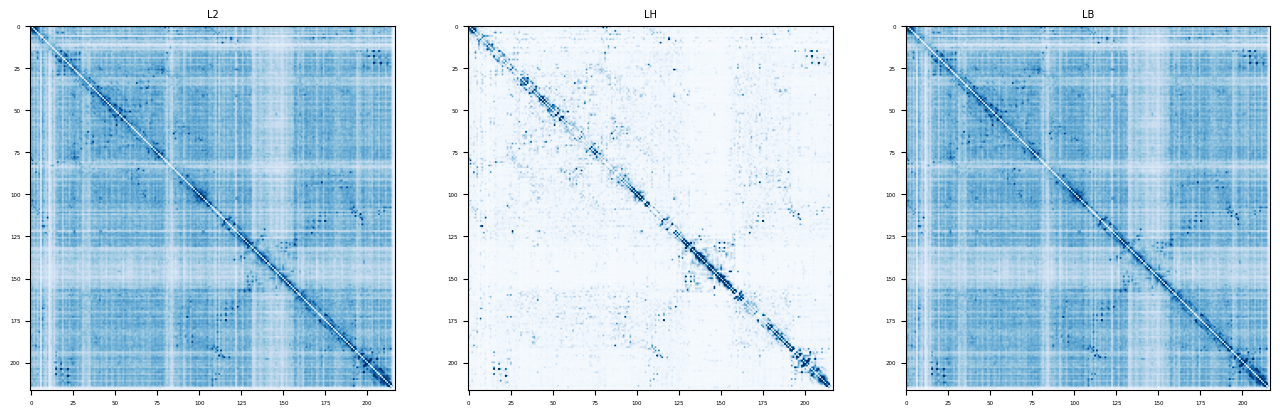

In [49]:
plt.figure(figsize=[16,5],facecolor="white")

plt.subplot(131)
plt.title("L2")
plt.imshow(get_mtx(W_L2)[0], cmap="Blues",vmin=0,vmax=0.8)

plt.subplot(132)
plt.title("LH")
plt.imshow(get_mtx(W_LH)[0], cmap="Blues",vmin=0,vmax=0.8)

plt.subplot(133)
plt.title("LB")
contact_Bs = get_sin_contact(prots_ASR[0], W_LB)
contact_AN1 = get_sin_contact(prots_ASR[9], W_LB)
plt.imshow(get_mtx(W_L2)[0], cmap="Blues",vmin=0,vmax=0.8)
